In [1]:
from IPython.core.display import HTML

display(HTML("<style>.container { width:calc(100% - 350px) !important; } body { height:100% !important; }</style>"))

In [ ]:
!pip install inflection
!pip install --upgrade deep_tracking
!pip install --upgrade time_series_cross_validation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
from datetime import datetime, timedelta
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as mt
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
#from deep_tracking import Tracker
#from time_series_cross_validation import Time_series_CV
import sys
sys.path.insert(0, '../deep_tracking')
from deep_tracking import Tracker
sys.path.insert(0, '../time_series_cross_validation')
import time_series_cross_validation as tscv
sys.path.insert(0, '../feature_selection_tools')
import feature_selection_tools as fst

In [3]:
trk = Tracker()
trk.load('tracker')

Decompressing data...
Tracker loaded from tracker.trk!


In [ ]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

# Business Problem

## The Business

<img src="rossmann.jpg" alt="Rossmann logo" width="300">
Rossmann its one of the largest drug store chains in Europe with around 56k employers and more than 4000 stores.
The product range includes around 22k items and can vary depending of the size of the shop and the location. 
In addition to drugstore products with a focus on skin, hair, body, baby and health, Rossmann also offers others items like pet food, photo service and a large range of natural foods and wine.  
(last update 2019)

## The Problem

What is the store sales prediction for the next six month?

The CEO has difficulty defining the amount of money to invest in renovating some stores.
Talking to the CEO, he explained that knowing the total sales for each store for the next six months, he would be able to define whether or not to invest in renovations.
Understanding that the solution suggested by the CEO seems to solve your problem. It was proposed the development of a machine learning algorithm with the objective of predicting the revenue of each store for the next six weeks.

# Correlation Hypotheses

What could correlate (interfere) with the total sales in each store?
<img src="hipotesis.png" alt="Rossmann logo" width="100%">

## Time

- There is a seasonality in the volume of the sales (general business knowledge)
- More sales are made on holidays (general perception of the sales team)  
- More sales are made on promotions day (general perception of the sales team)

## Products

- Products on sale sell more
- Prices do not determine the volume of sales of a given product
- Products with active marketing campaigns sell more
- Products with more exhibition sell more
- Products with stock sell more

## Localization

- Proximity to related businesses increases sales
- Stores located in populated areas sell more
- The total sales pattern changes by country

## Stores

- Stores with a greater variety of products sell more
- Bigger stores sell more
- Stores with close competitors sell less

## Clients

- The total that the customer has already purchased on the network is related to their purchase pattern
- Customers with more children buy more
- Customers with higher salaries buy more
- Age impacts the volume spent by customers
- The profession has an impact on the volume spent by the client
- If the client has a family, he spends more
- Customers with higher purchase frequency tend to spend more

# Data Collection

According to the hypotheses above, the following list of data to be collected was raised:
- Daily sales amount
- Data
- There is a holiday? Which One?
- Is it a promotional day? Which One?
- The products selled on that day with:
  - Its price
  - If was on sale
  - If there was a marketing campaign
  - If it was exhibited
  - The stock
- The proximity of the store with related business
- Kind of area the store is located (country/city)
- Country where the store is located
- Variety of products of the store
- Size (area) of the store
- Proximity with competitors

As this is a fictitious project carried out using data provided by Rossmann.  
The data collection step is summarized in picking up the datasets available at the link below:  
https://www.kaggle.com/competitions/rossmann-store-sales/data  
Hypotheses that depend on features that are not in the dataset will be automatically discarded.

## Data Loading

In [ ]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [ ]:
df_raw = df_sales_raw.merge(df_stores_raw, how='left', on='Store')

In [6]:
print('''Data loaded from https://www.kaggle.com/competitions/rossmann-store-sales/data
The two datasets found there were joined by the column Store.
The new dataset is available by the variable df_raw.''')

Data loaded from https://www.kaggle.com/competitions/rossmann-store-sales/data
The two datasets found there were joined by the column Store.
The new dataset is available by the variable df_raw.


# Data Exploration & Preparation (DE&P)

In [46]:
#trk = Tracker(df_raw.copy())
print('''All data manipulations will be tracked through the Tracker class in order to better organize them.
The use of the tracker method, allow the execution of the DE&P method as well.''')

Decompressing data...
Tracker loaded from tracker.trk!
All data manipulations will be tracked through the Tracker class in order to better organize them.
The use of the tracker method, allow the execution of the DE&P method as well.


## Initial Data Summary

In [17]:
data = trk.get_backup(-1)

In [19]:
df_ids = pd.DataFrame() 
df_ids.index = data.columns
df_ids['column'] = data.columns
df_ids.loc['Store', 'description'] = 'a unique Id for each store'  
df_ids.loc['DayOfWeek', 'description'] = 'day of week'  
df_ids.loc['Date', 'description'] = 'data'  
df_ids.loc['Sales', 'description'] = 'the turnover for any given day (this is what you are predicting)'  
df_ids.loc['Customers', 'description'] = 'the number of customers on a given day'
df_ids.loc['Open', 'description'] = 'an indicator for whether the store was open: 0 = closed, 1 = open'
df_ids.loc['Promo', 'description'] = 'indicates whether a store is running a promo on that day'
df_ids.loc['StateHoliday', 'description'] = ' indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None'
df_ids.loc['SchoolHoliday', 'description'] = 'indicates if the (Store, Date) was affected by the closure of public schools'
df_ids.loc['StoreType', 'description'] = 'differentiates between 4 different store models: a, b, c, d'
df_ids.loc['Assortment', 'description'] = 'describes an assortment level: a = basic, b = extra, c = extended'  
df_ids.loc['CompetitionDistance', 'description'] = 'distance in meters to the nearest competitor store'
df_ids.loc['CompetitionOpenSinceMonth', 'description'] = 'gives the approximate year and month of the time the nearest competitor was opened'
df_ids.loc['CompetitionOpenSinceYear', 'description'] = 'gives the approximate year and month of the time the nearest competitor was opened'
df_ids.loc['Promo2', 'description'] = 'Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating'
df_ids.loc['Promo2SinceWeek', 'description'] = 'describes the year and calendar week when the store started participating in Promo2'
df_ids.loc['Promo2SinceYear', 'description'] = 'describes the year and calendar week when the store started participating in Promo2'
df_ids.loc['PromoInterval', 'description'] = 'describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store'

In [21]:
df_ids['dtype'] = data.dtypes

In [22]:
df_ids['NAs'] = data.isna().sum()

In [23]:
df_ids['uniques'] = data.nunique()

In [24]:
print(f'df_raw contains {data.shape[0]} lines with {data.shape[1]} columns each')
df_ids_styled = (df_ids.style.set_properties(subset=['column', 'description'], **{'text-align': 'left'})
                             .set_properties(subset=['dtype', 'NAs', 'uniques'], **{'text-align': 'center'})
                             .set_table_styles([{'selector': 'th', 
                                                 'props': [('text-align', 'left')]}])
                             .hide(axis='index'))
df_ids_styled

df_raw contains 1017209 lines with 18 columns each


column,description,dtype,NAs,uniques
Store,a unique Id for each store,int64,0,1115
DayOfWeek,day of week,int64,0,7
Date,data,object,0,942
Sales,the turnover for any given day (this is what you are predicting),int64,0,21734
Customers,the number of customers on a given day,int64,0,4086
Open,"an indicator for whether the store was open: 0 = closed, 1 = open",int64,0,2
Promo,indicates whether a store is running a promo on that day,int64,0,2
StateHoliday,"indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None",object,0,4
SchoolHoliday,"indicates if the (Store, Date) was affected by the closure of public schools",int64,0,2
StoreType,"differentiates between 4 different store models: a, b, c, d",object,0,4


## All Columns

### Rename

In [6]:
def rename_all_columns(data):
    old_names = data.columns
    new_names = list(map(inflection.underscore, old_names))
    data.columns = new_names
    return data

trk.add_process('_general_', 'rename', rename_all_columns, 'Rename all columns to snake_case')

print('Renamed all columns to snake_case pattern')

Renamed all columns to snake_case pattern


In [7]:
trk.backup()

## sales

### #1 Univariated Analysis

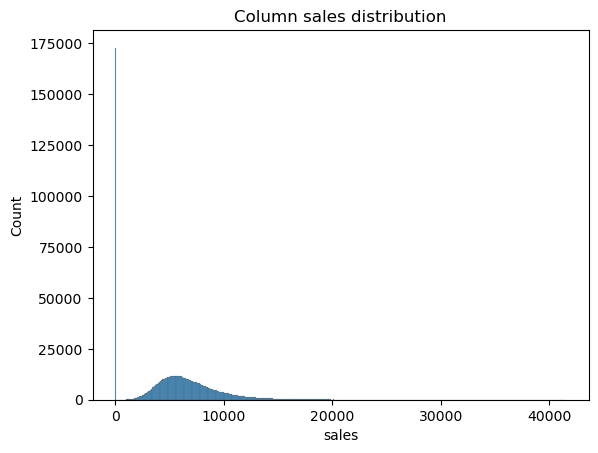

In [8]:
data = trk.get_backup(('_general_', 'rename'), method='<=')

sns.histplot(data['sales']);
plt.title('Column sales distribution');

In [9]:
print('''There are a lot of rows with sales equal to 0. 
It is interesting to drop the lines with 0 values to consider them as NA values.''')

There are a lot of rows with sales equal to 0. 
It is interesting to drop the lines with 0 values to consider them as NA values.


### NAs

In [10]:
def treatNA_sales(data):
    data = data[(~data['sales'].isna()) & (data['sales'] != 0)]
    return data

trk.add_process('sales', 'treatNA', treatNA_sales, 'Drop lines with NAs or 0 values to sales')

print('Droped lines with sales equal to 0.')

Droped lines with sales equal to 0.


In [11]:
trk.backup()

### #2 Univariated Analysis

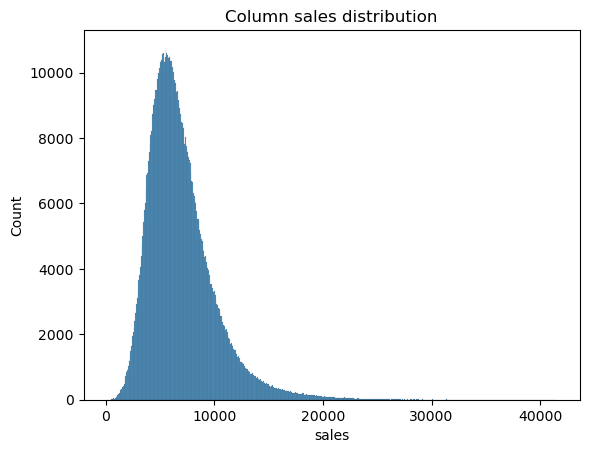

In [12]:
data = trk.get_backup(('sales', 'treatNA'), method='<=')

sns.histplot(data['sales'])
plt.title('Column sales distribution');

In [13]:
print('''Sales column has distribution near to a normal distribution.
How the machine learning models handle better with normal distributions, 
its interesting to apply a log function to model the distribution closer to a normal''')

Sales column has distribution near to a normal distribution.
How the machine learning models handle better with normal distributions, 
its interesting to apply a log function to model the distribution closer to a normal


### Reshape

In [25]:
def reshape_sales(data):
    data.loc[:, 'sales'] = np.log1p(data['sales'])
    return data

trk.add_process('sales', 'reshape', reshape_sales, 'Reshape column sales to get closer to a normal distribution', False)

print('Added process to reshape column sales to get closer to a normal distribution. The process its not tracked.')

Added process to reshape column sales to get closer to a normal distribution. The process its not tracked.


### #3 Univariated Analysis

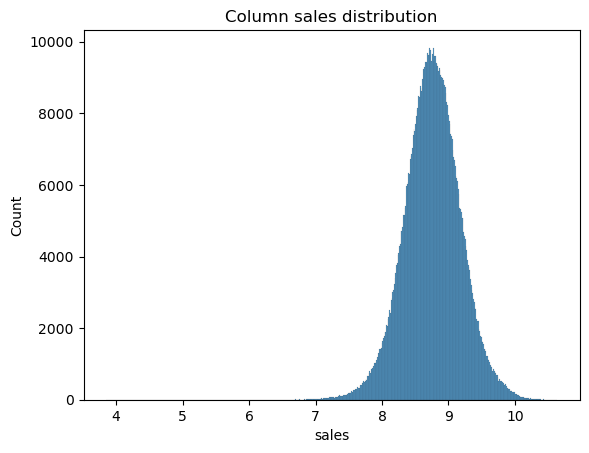

In [26]:
data = trk.get_backup(('sales', 'treatNA'), method='<=')
data = trk.run(data, [('sales', 'reshape')])

sns.histplot(data['sales'])
plt.title('Column sales distribution');

In [27]:
print('Sales distribution curve was well normalized.')

Sales distribution curve was well normalized.


## store

### Univariated Analysis

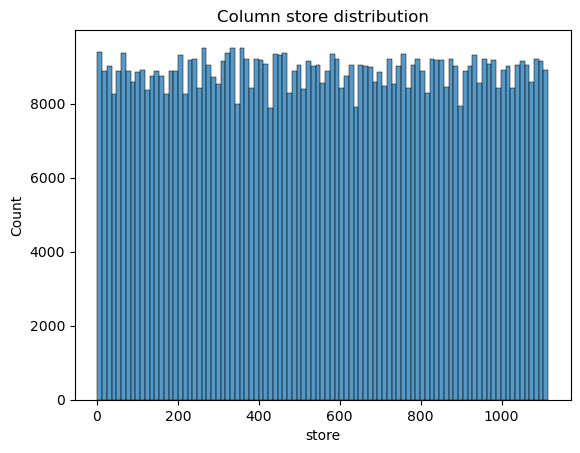

In [16]:
data = trk.data

sns.histplot(data['store'])
plt.title('Column store distribution');

In [17]:
print('''There is no pattern in the column store distribution, 
showing that the sales records are well distributed over the stores (balanced data).''')

There is no pattern in the column store distribution, 
showing that the sales records are well distributed over the stores (balanced data).


### NAs

In [18]:
data = trk.data
if (min(data['store'].unique()) > 0) and (sum(data['store'].isna()) == 0):
    print('No NA found.')
else:
    print('Please check here.')
    
print('''
Rules considered to verify the presence of NAs:
1 - NA values
2 - 0 values
''')

No NA found.

Rules considered to verify the presence of NAs:
1 - NA values
2 - 0 values



### Bivariated Analysis

Looking to the variations of sum and mean for the column sales grouped by the column store...


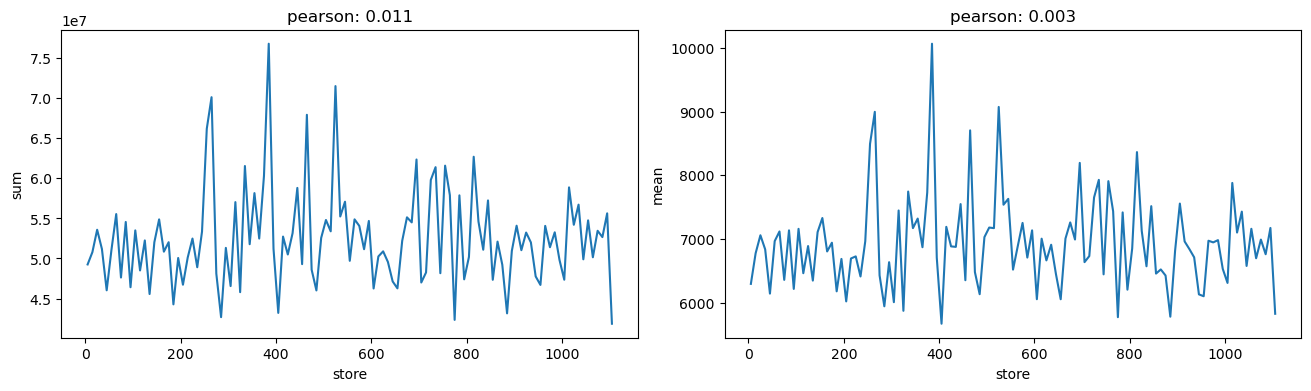

In [19]:
data = trk.data
data['store'] = pd.cut(data['store'], bins=np.arange(0, 1111, 10), labels=np.arange(5, 1110, 10))
data['store'] = data['store'].astype('float64')
data = (data.loc[:, ['store', 'sales']]
            .groupby('store')
            .agg(['sum', 'mean'])
            .droplevel(0, axis=1)
            .reset_index())

pearson_correlations = data.corr(method='pearson')

print('Looking to the variations of sum and mean for the column sales grouped by the column store...')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
sns.lineplot(x=data['store'], y=data['sum'], ax=ax1)
ax1.set_title('pearson: {:.3f}'.format(pearson_correlations.at['store', 'sum']))
sns.lineplot(x=data['store'], y=data['mean'], ax=ax2)
ax2.set_title('pearson: {:.3f}'.format(pearson_correlations.at['store', 'mean']))
fig.subplots_adjust(wspace=0.15)

In [20]:
print('''There is no apparent pattern when correlating store with sales.
Neither Pearson's correlation nor the graphs showed anything.''')

There is no apparent pattern when correlating store with sales.
Neither Pearson's correlation nor the graphs showed anything.


## date

### Type

In [21]:
def retype_date(data):
    data.loc[:, 'date'] = pd.to_datetime(data['date'])
    return data

trk.add_process('date', 'retype', retype_date, 'Retype column date from object to datetime64[ns]')

print('Retyped column date from object to datetime64[ns]')

Retyped column date from object to datetime64[ns]


### Univariated Analysis

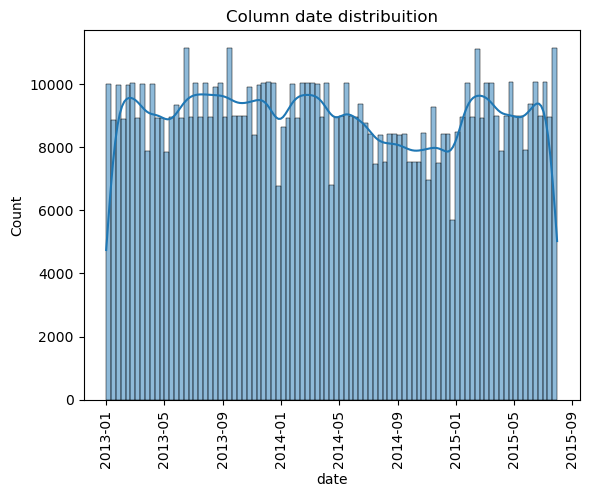

In [22]:
data = trk.data

sns.histplot(data['date'], kde=True)
plt.title('Column date distribuition')
plt.xticks(rotation=90);

In [23]:
print('''There is no pattern in the column 'date' distribution, 
showing that the sales records are well distributed over the date (balanced data).''')

There is no pattern in the column 'date' distribution, 
showing that the sales records are well distributed over the date (balanced data).


### Bivariated Analysis

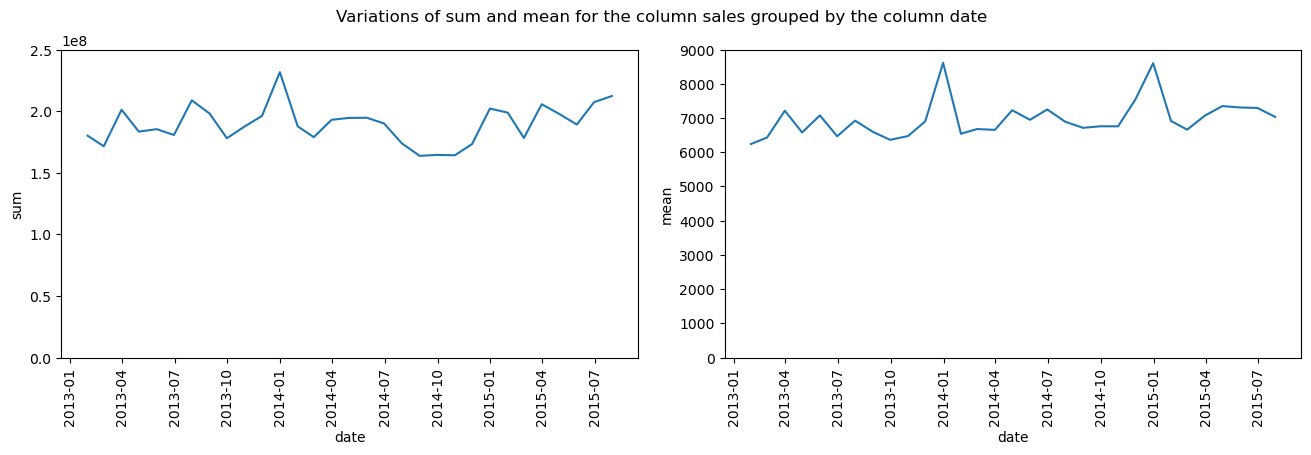

In [24]:
data = trk.data
data = (data.loc[:, ['date', 'sales']]
            .groupby(pd.Grouper(key='date', freq='M'))
            .agg(['sum', 'mean'])
            .droplevel(0, axis=1)
            .reset_index())
pearson_correlations = data.corr(method='pearson')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
sns.lineplot(x=data['date'], y=data['sum'], ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=90)
ax1.set_ylim([0,250000000])
sns.lineplot(x=data['date'], y=data['mean'], ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=90)
ax2.set_ylim([0,9000])
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variations of sum and mean for the column sales grouped by the column date');

In [25]:
print('''Observing the curves with the sum and mean of sales over time,
it is not possible to point out any pattern referring to the direction of the curve. 
However, there are patterns of peaks at the end/beginning of years.
They will be better analyzed performing the same comparison but using the month or week of the year column (both in numerical mode) as a grouper.''')

Observing the curves with the sum and mean of sales over time,
it is not possible to point out any pattern referring to the direction of the curve. 
However, there are patterns of peaks at the end/beginning of years.
They will be better analyzed performing the same comparison but using the month or week of the year column (both in numerical mode) as a grouper.


## customers

In [26]:
print('''It will not be possible to use the customers column since it will not be available at the time of the prediction.
To be able to use it, another prediction could be done for it.
However, I will analyze how it is distributed and how it relates to sales.''')

It will not be possible to use the customers column since it will not be available at the time of the prediction.
To be able to use it, another prediction could be done for it.
However, I will analyze how it is distributed and how it relates to sales.


### Univariated Analysis

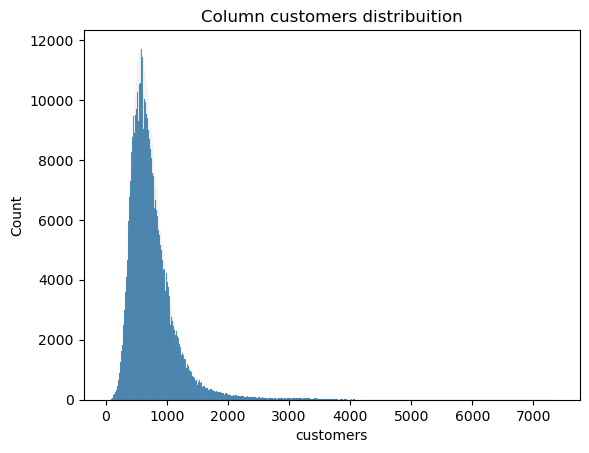

In [27]:
data = trk.data

sns.histplot(data['customers'])
plt.title('Column customers distribuition');

In [28]:
kurtosis = data['customers'].kurtosis()
skew = data['customers'].skew()
print(f'The column has a normal distribution with high positive kurtosis ({kurtosis:.2f}) and lower positive skew ({skew:.2f}).')

The column has a normal distribution with high positive kurtosis (13.32) and lower positive skew (2.79).


### Bivariated Analysis

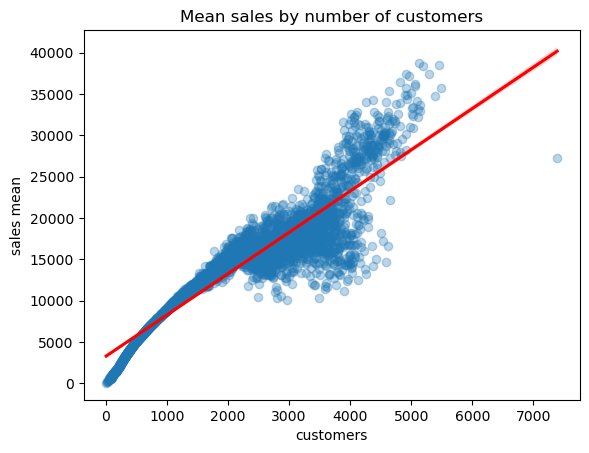

In [29]:
data = trk.data

data = (data.loc[:, ['customers', 'sales']]
            .groupby('customers')
            .mean()
            .reset_index())

sns.regplot(x=data['customers'], 
            y=data['sales'], 
            scatter_kws={'alpha': 0.3},
            line_kws={'color': 'red'})
plt.ylabel('sales mean')
plt.title('Mean sales by number of customers');

In [30]:
print('''According to the graph above, there is a very strong relationship between the number of sellers and sales volume.
This ratio follows a precise curve up to about 2000 customers. From then on it disperses.
It would be interesting to granularize this relation with other variables (store_type and assortment for example) 
to verify if the dispersion after 2000 customers reduces.''')

According to the graph above, there is a very strong relationship between the number of sellers and sales volume.
This ratio follows a precise curve up to about 2000 customers. From then on it disperses.
It would be interesting to granularize this relation with other variables (store_type and assortment for example) 
to verify if the dispersion after 2000 customers reduces.


### Drop

In [35]:
def drop_customers(data):
    return data.drop(columns=['customers'])

trk.add_process('customers', 'drop', drop_customers, 'Drop column customers', False)

print('Added process to drop column custmers.')

Added process to drop column custmers.


In [31]:
trk.backup()

## open

In [35]:
data = trk.get_backup(('date', 'retype'), '<=')
if sum(data['open'] == 0) == 0:
    print('''There is no lines with the column open equal to 0. 
They are all droped when removing the lines with no sales.''')
else: 
    print('CHECK HERE!')

There is no lines with the column open equal to 0. 
They are all droped when removing the lines with no sales.


### Drop

In [36]:
def drop_open(data):
    return data.drop(columns=['open'])

trk.add_process('open', 'drop', drop_open, 'Drop column open')

print('Droped column open')

Droped column open


## promo

### Univariated Analysis

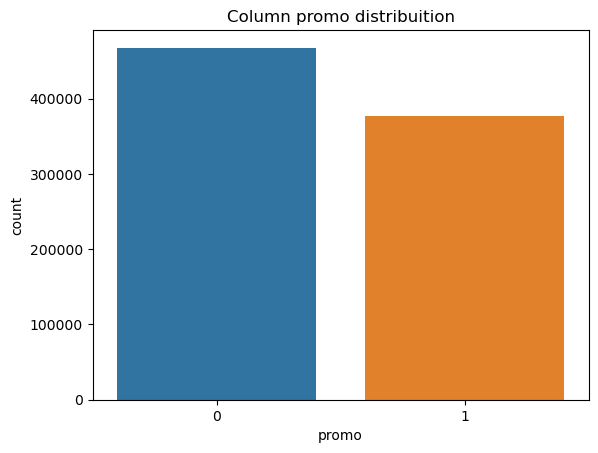

In [37]:
data = trk.data

sns.countplot(x=data['promo'])
plt.title('Column promo distribuition');

### Bivariated Analysis

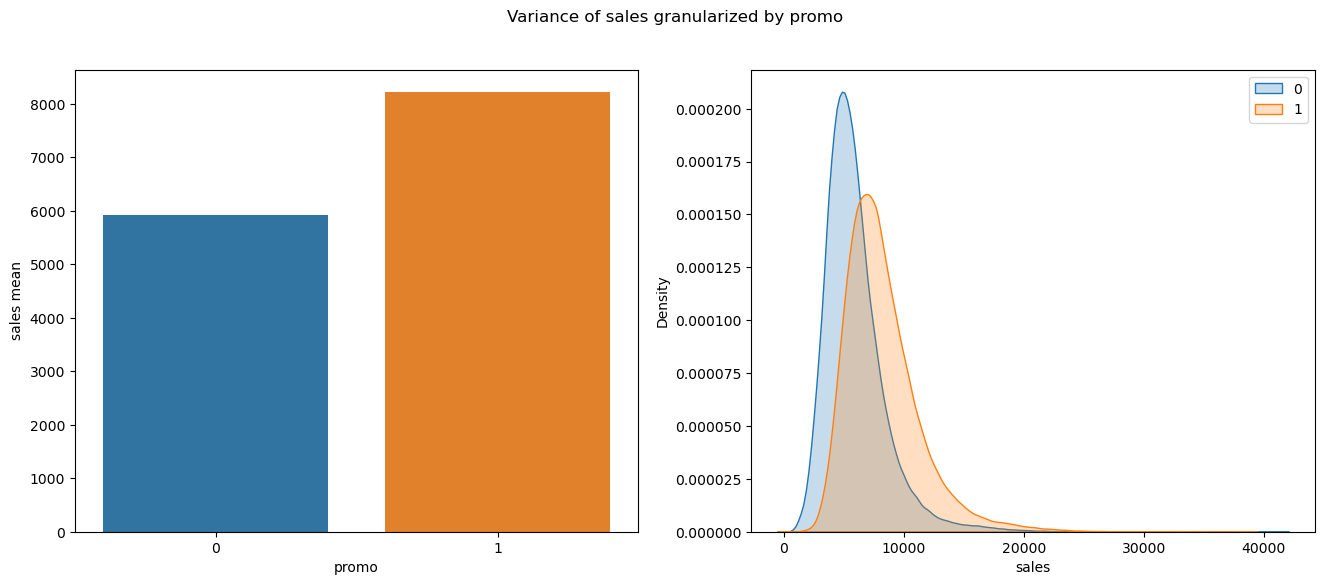

In [38]:
data = trk.data

data_aux = data[['promo', 'sales']].groupby('promo').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='promo', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['promo'] == 0]['sales'], label='0', shade=True)
sns.kdeplot(data[data['promo'] == 1]['sales'], label='1', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by promo');

In [39]:
print('Promotion days sell on average 2000 more than non-promotion days')

Promotion days sell on average 2000 more than non-promotion days


## state_holiday

### Labels

In [40]:
def relabel_state_holiday(data):
    data['state_holiday'] = data['state_holiday'].map(lambda x: {'a': 'public',
                                                                 'b': 'easter',
                                                                 'c': 'christmas',
                                                                 '0': 'no'}.get(x, x))
    return data

trk.add_process('state_holiday', 'relabel', relabel_state_holiday, 'Relabel the column state_holiday to more descriptive names (public, easter, christmas, no)')

print('Relabeled the column state_holiday to more descriptive names (public, easter, christmas, no)')

Relabeled the column state_holiday to more descriptive names (public, easter, christmas, no)


### Univariated Analysis

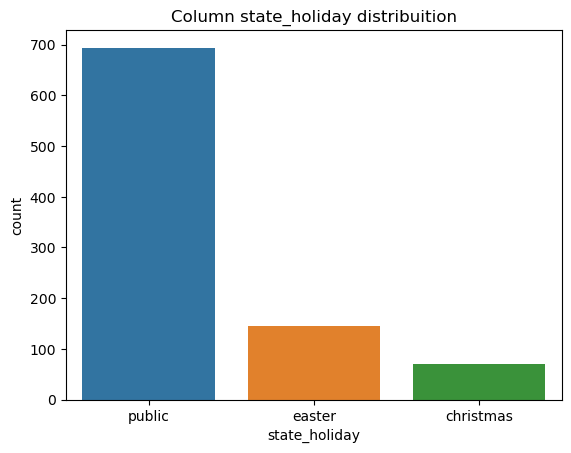

In [41]:
data = trk.data
data = data[data['state_holiday'] != 'no']

sns.countplot(x=data['state_holiday'])
plt.title('Column state_holiday distribuition');

In [42]:
print('''There is a total of public holidays greater than others.
Makes sense since there are more public (common) holidays along the year when compared with easter and christmas.
The total of christmas holidays smaller than easter its because the range of the data has three easter and two christmas.
Also, probably there are more stores that dont open in christmas than easter''')

There is a total of public holidays greater than others.
Makes sense since there are more public (common) holidays along the year when compared with easter and christmas.
The total of christmas holidays smaller than easter its because the range of the data has three easter and two christmas.
Also, probably there are more stores that dont open in christmas than easter


### Bivariated Analysis

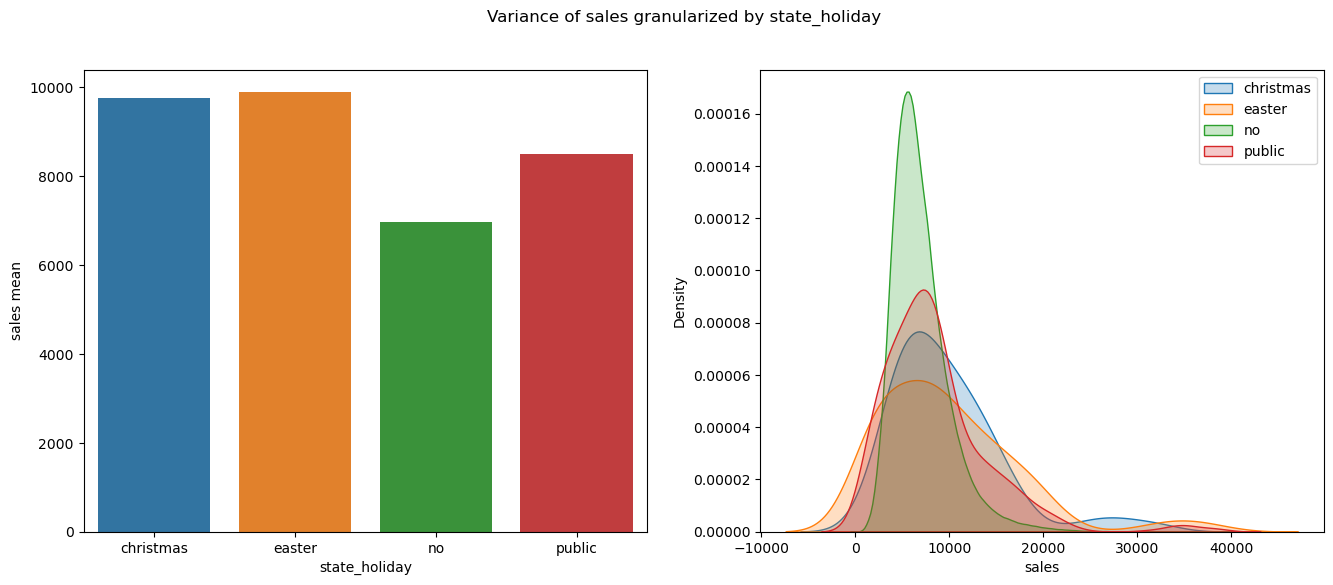

In [43]:
data = trk.data

data_aux = data[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
sns.kdeplot(data[data['state_holiday'] == 'easter']['sales'], label='easter', shade=True)
sns.kdeplot(data[data['state_holiday'] == 'no']['sales'], label='no', shade=True)
sns.kdeplot(data[data['state_holiday'] == 'public']['sales'], label='public', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by state_holiday');

In [44]:
print('''There is a pattern of bumps on holiday days. 
It is interesting to try to identify if there are any other variables related to this pattern in the multivariate analysis. 
My suggestion would be the size of the store or the assortment.''')

There is a pattern of bumps on holiday days. 
It is interesting to try to identify if there are any other variables related to this pattern in the multivariate analysis. 
My suggestion would be the size of the store or the assortment.


### Encode

In [45]:
def encode_state_holiday(data):
    le = LabelEncoder()
    data['state_holiday'] = le.fit_transform(data['state_holiday'])
    return data
    
trk.add_process('state_holiday', 'encode', encode_state_holiday, 'Add process to do the label encode on state_holiday', False)

print('Add process to do the label encode on state_holiday')

Add process to do the label encode on state_holiday


In [46]:
trk.backup()

## school_holiday

### Univariated Analysis

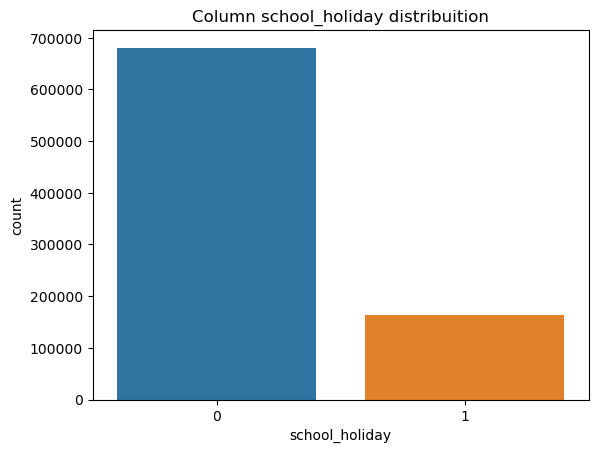

In [47]:
data = trk.data

sns.countplot(x=data['school_holiday'])
plt.title('Column school_holiday distribuition');

In [48]:
print('''As expected. There is a strong imbalance in the data with a much higher number of days without school holidays.''')

As expected. There is a strong imbalance in the data with a much higher number of days without school holidays.


### Bivariated Analysis

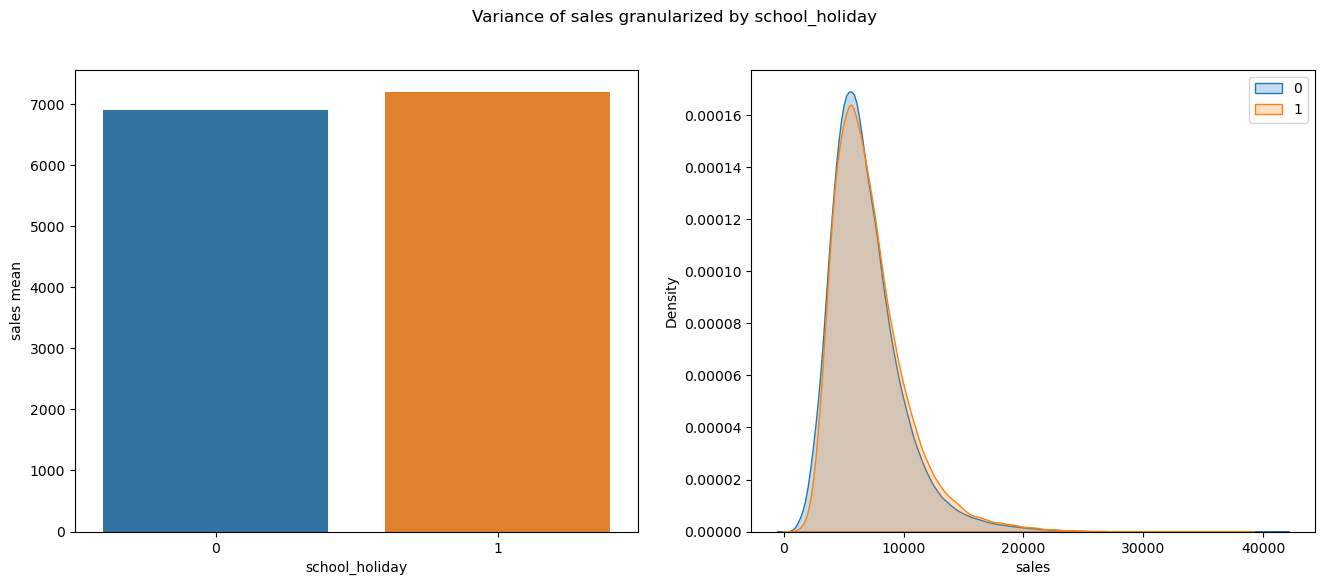

In [49]:
data = trk.data

data_aux = data[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['school_holiday'] == 0]['sales'], label='0', shade=True)
sns.kdeplot(data[data['school_holiday'] == 1]['sales'], label='1', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by school_holiday');

In [50]:
print('The variable school_holiday has a very small impact on sales volume.')

The variable school_holiday has a very small impact on sales volume.


## store_type

### Univariated Analysis

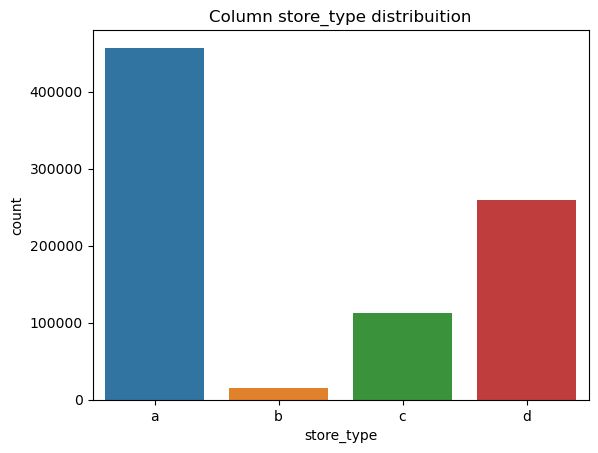

In [51]:
data = trk.data

sns.countplot(x=data['store_type'].sort_values())
plt.title('Column store_type distribuition');

In [52]:
print('There is much more data for the stores type a and d. No much data for the store b')

There is much more data for the stores type a and d. No much data for the store b


### Bivariated Analysis

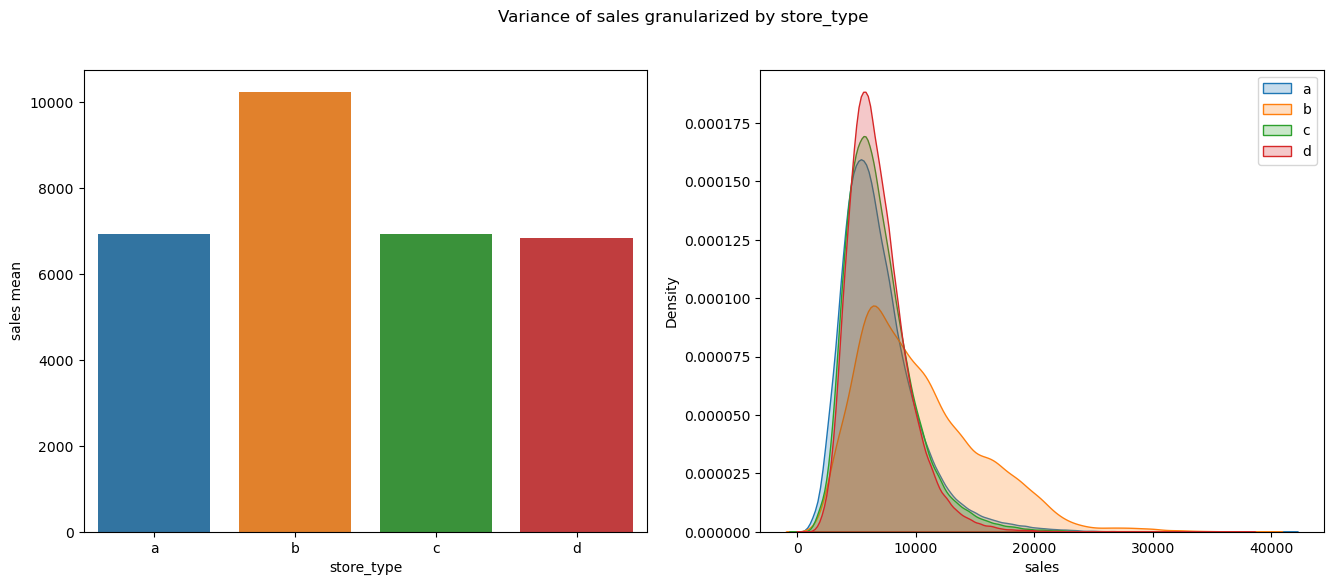

In [53]:
data = trk.data

data_aux = data[['store_type', 'sales']].groupby('store_type').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='store_type', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(data[data['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(data[data['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(data[data['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by store_type');

In [54]:
print('Store type b is the only one that has a different sales pattern when compared to the other stores, as well as a higher average sales')

Store type b is the only one that has a different sales pattern when compared to the other stores, as well as a higher average sales


### Encode

In [55]:
def relabel_store_type(data):
    le = LabelEncoder()
    data['store_type'] = le.fit_transform(data['store_type'])
    return data

trk.add_process('store_type', 'relabel', relabel_store_type, 'Make label encoder on store_type', False)

print('Added process to make label encoder on store_type.')

Added process to make label encoder on store_type.


## assortment

### Labels

In [56]:
def relabel_assortment(data):
    data['assortment'] = data['assortment'].map(lambda x: {'a': 'basic',
                                                           'b': 'extra',
                                                           'c': 'extended'}.get(x, x))
    return data

trk.add_process('assortment', 'relabel', relabel_assortment, 'Relabel the column assortment to more descriptive names (basic, extra, extended)')

print('Relabeled the column assortment to more descriptive names (basic, extra, extended)')

Relabeled the column assortment to more descriptive names (basic, extra, extended)


### Univariated Analysis

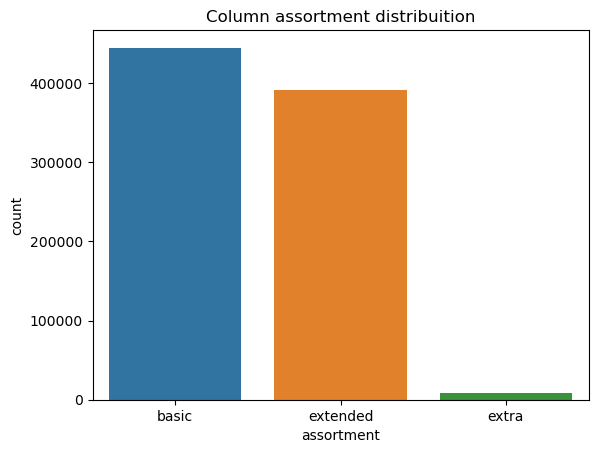

In [57]:
data = trk.data

sns.countplot(x=data['assortment'].sort_values())
plt.title('Column assortment distribuition');

In [58]:
print('There is a strong imbalance of data with almost non-existent quantity for stores with assortment type extra')

There is a strong imbalance of data with almost non-existent quantity for stores with assortment type extra


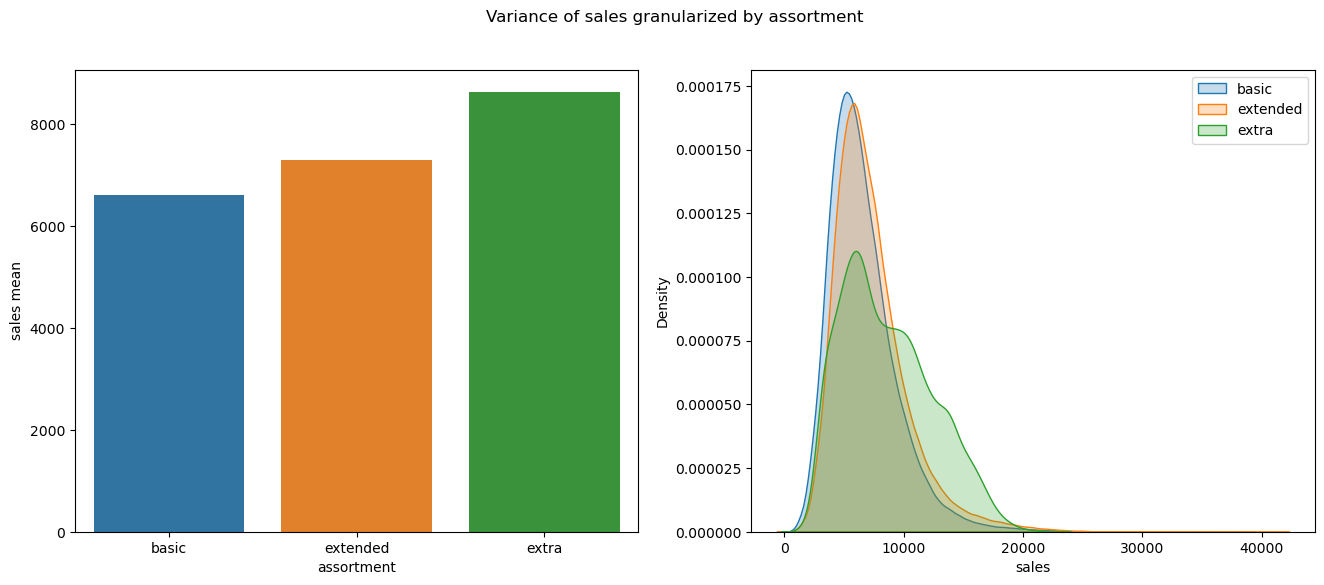

In [59]:
data = trk.data

data_aux = data[['assortment', 'sales']].groupby('assortment').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='assortment', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(data[data['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(data[data['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by assortment');

In [60]:
print('''The average sales have a growing trend for the order: basic -> extended -> extra.
The sales distribution curves for basic and extended stores are very similar.
The curve for stores of the extra type differs from the others.
This curve for assortment extra is very similar to the curve for stores_type b. 
It's interesting to check if the two variables are correlated at the multivariable analysis.''')

The average sales have a growing trend for the order: basic -> extended -> extra.
The sales distribution curves for basic and extended stores are very similar.
The curve for stores of the extra type differs from the others.
This curve for assortment extra is very similar to the curve for stores_type b. 
It's interesting to check if the two variables are correlated at the multivariable analysis.


### Encode

In [61]:
def encode_assortment(data):
    oe = OrdinalEncoder(categories=[['basic', 'extra', 'extended']], dtype='int64')
    data['assortment'] = oe.fit_transform(data[['assortment']])
    return data

trk.add_process('assortment', 'encode', encode_assortment, 'Make ordinal encoder with assortment order: basic, extra, extended.', False)

print('Added process to make ordinal encoder with assortment order: basic, extra, extended.')

Added process to make ordinal encoder with assortment order: basic, extra, extended.


## competition_distance

### NA

In [64]:
data = trk.get_backup(('assortment', 'encode'), method='<=')
NAs = sum(data['competition_distance'].isna())

print(f'''There is {NAs} values. 
Understanding that values with NAs means that the store hasn't competition.
And considerig that the
It will be set NA values as a outlier value.''')

There is 2186 values. 
Understanding that values with NAs means that the store hasn't competition.
And considerig that the
It will be set NA values as a outlier value.


In [65]:
def treatNA_competition_distance(data):
    data.loc[data['competition_distance'].isna(), 'competition_distance'] = data['competition_distance'].mean() + 3 * data['competition_distance'].std()     
    return data

trk.add_process('competition_distance', 'treatNA', treatNA_competition_distance, 'Change NA values for competitio_distance to 3 times standard desviation')

print('Changed NA values for competitio_distance to 3 times standard desviation')

Changed NA values for competitio_distance to 3 times standard desviation


### Univariated Analysis

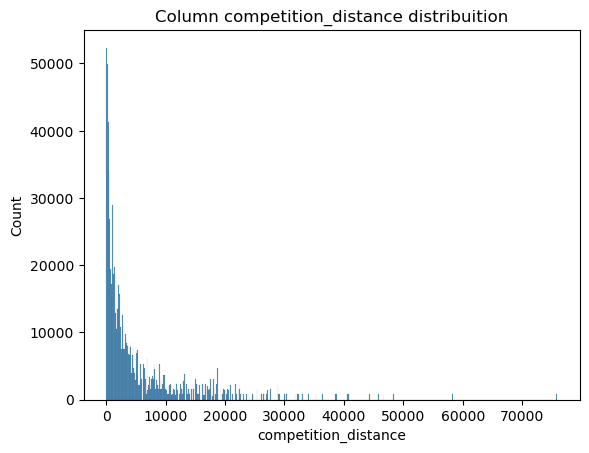

In [66]:
data = trk.data

sns.histplot(data['competition_distance'])
plt.title('Column competition_distance distribuition');

In [67]:
print('There are much more stores with competitors near than stores with competitors far away.')

There are much more stores with competitors near than stores with competitors far away.


### Bivariated Analysis

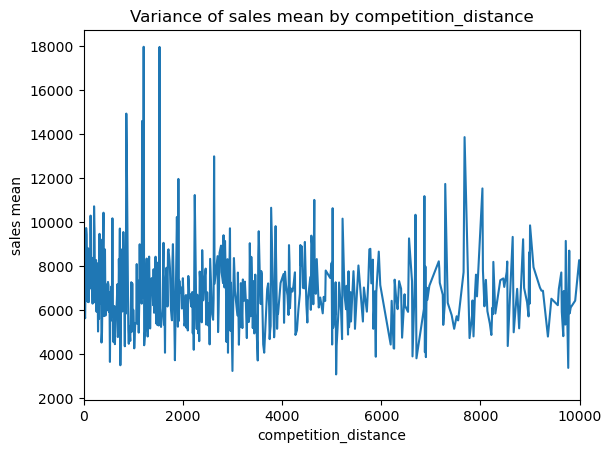

In [68]:
data = trk.data

data = data[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

sns.lineplot(x=data['competition_distance'], y=data['sales'])
plt.ylabel('sales mean')
plt.xlim([0, 10000])
plt.title('Variance of sales mean by competition_distance');

In [69]:
print('''The graph above got too noisy. Let's try group the competition_distance.
OBS.: Omitted data with distance from 10000 to 70000.''')

The graph above got too noisy. Let's try group the competition_distance.
OBS.: Omitted data with distance from 10000 to 70000.


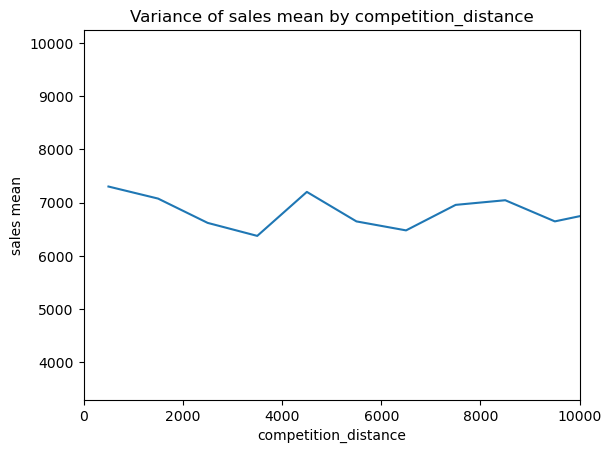

In [70]:
data = trk.data

data['competition_distance'] = pd.cut(data['competition_distance'], bins=range(0, 100000, 1000), labels=range(500, 99500, 1000))
data = data[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

sns.lineplot(x=data['competition_distance'], y=data['sales'])
plt.ylabel('sales mean')
plt.xlim([0, 10000])
plt.title('Variance of sales mean by competition_distance');

In [71]:
print('''There is a small drop in average sales as the distance to the nearest competitor increases.
Let's take a closer look at smaller distances and in a more granular way''')

There is a small drop in average sales as the distance to the nearest competitor increases.
Let's take a closer look at smaller distances and in a more granular way


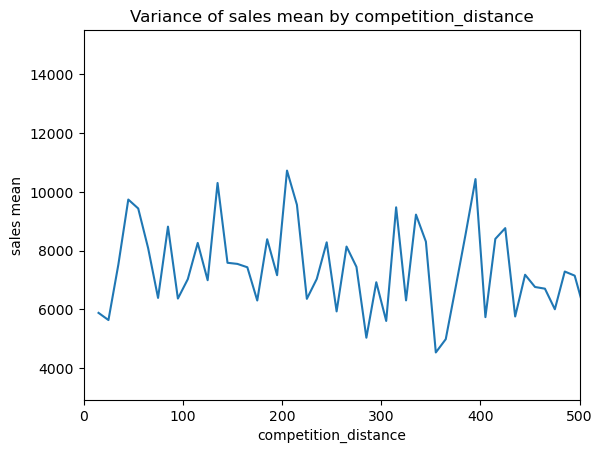

In [72]:
data = trk.data

data = data[data['competition_distance'] < 1000]
data['competition_distance'] = pd.cut(data['competition_distance'], bins=range(0, 1000, 10), labels=range(5, 995, 10))
data = data[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

sns.lineplot(x=data['competition_distance'], y=data['sales'])
plt.ylabel('sales mean')
plt.xlim([0, 500])
plt.title('Variance of sales mean by competition_distance');

In [73]:
print('''Nothing!
Just the same pattern already observed at the previows graph.
This variable don't look to be important to predict sales.''')

Nothing!
Just the same pattern already observed at the previows graph.
This variable don't look to be important to predict sales.


### Rescale

In [74]:
def rescaler_competition_distance(data):
    rs = RobustScaler(with_centering=False, quantile_range=(0, 75))
    data['competition_distance'] = rs.fit_transform(data[['competition_distance']])
    return data

trk.add_process('competition_distance', 'rescaler', rescaler_competition_distance, 'Rescale competition_distance using the min value and the third quantile', False)

print('Add proccess to rescale competition_distance using the min value and the third quantile')

Add proccess to rescale competition_distance using the min value and the third quantile


## competition_time

In [75]:
print('''This variable is going to be enginered using the calc below:
data - (competition_open_since_month + competition_open_since_year)
considering always the first day of the month.
This way, this variable means how much days the store has a competitor in that day.
''')

This variable is going to be enginered using the calc below:
data - (competition_open_since_month + competition_open_since_year)
considering always the first day of the month.
This way, this variable means how much days the store has a competitor in that day.



### Feature Engineering (self)

In [76]:
def create_competition_time(data):
    def get_data(x):
        if pd.notna(x['competition_open_since_year']) and pd.notna(x['competition_open_since_month']):
            return (x['date'] - datetime(int(x['competition_open_since_year']), int(x['competition_open_since_month']), 1)).days
        return np.nan
    data['competition_time'] = data.apply(get_data, axis=1)
    return data

trk.add_process('competition_time', 'create', create_competition_time, 'Create variable competiton_time')

print('Created variable competiton_time')

Created variable competiton_time


In [77]:
trk.backup()

### drop (competition_open_since_year/month)

In [78]:
def drop_competition_open_since_year_month(data):
    data = data.drop(columns=['competition_open_since_year', 'competition_open_since_month'])
    return data

trk.add_process('competition_open_sinceyear/month', 'drop', drop_competition_open_since_year_month, 'Drop variables competition_open_since_year/month')

print('Droped variables competition_open_since_year/month')

Droped variables competition_open_since_year/month


### Univariated Analysis

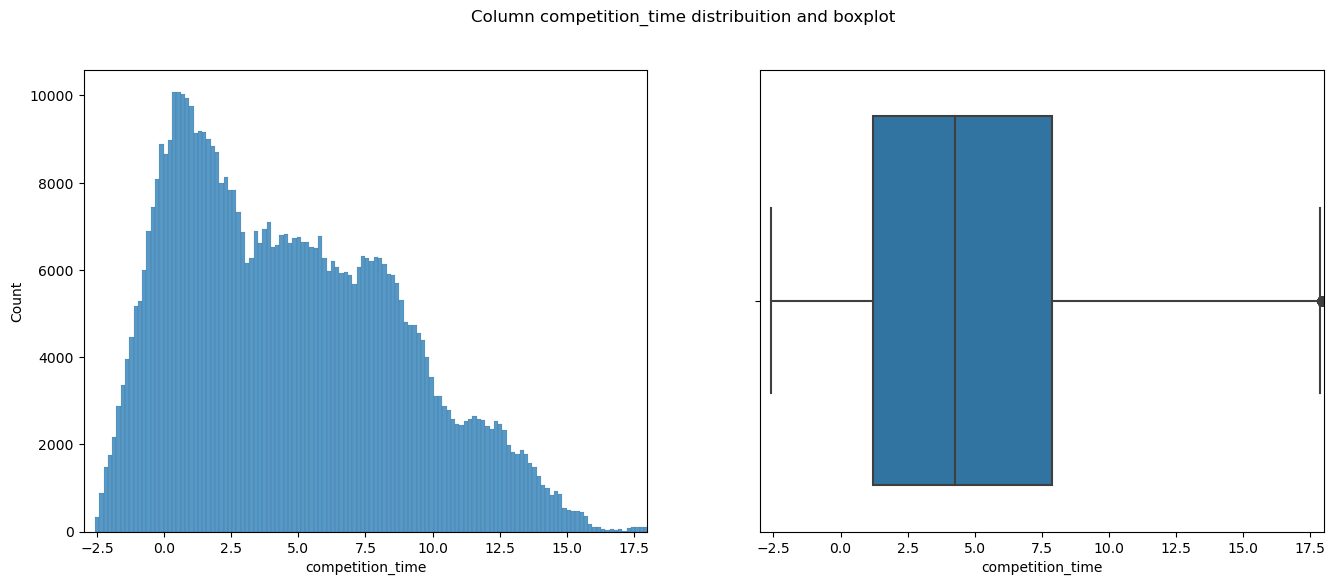

In [82]:
data = trk.get_backup(('competition_time', 'create'), method='<=')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['competition_time'] / 365)
plt.xlim([-3, 18])
plt.subplot(1, 2, 2)
sns.boxplot(x=data['competition_time'] / 365)
plt.xlim([-3, 18])
plt.suptitle('Column competition_time distribuition and boxplot');

In [83]:
print('There is a pattern of growing op')

There is a pattern of growing op


### Bivariated Analysis

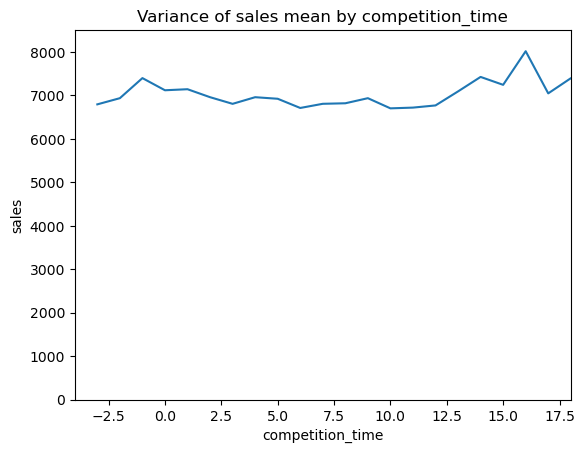

In [84]:
data = trk.data

data = data[data['competition_time'].notna()]
data['competition_time'] = (data['competition_time'] // 365).astype('int64')

data = data[['competition_time', 'sales']].groupby('competition_time').mean().reset_index()

sns.lineplot(x=data['competition_time'], y=data['sales'])
plt.xlim([-4, 18])
plt.ylim([0, 8500])
plt.title('Variance of sales mean by competition_time');

In [85]:
print('''There is a pattern where the average sales rises until just before the first competitor installs. 
From then, the curve starts to fall with a curved pattern and rises again for values greater than 10 years. 
Although not many stores (data) are seen for these last values.''')

There is a pattern where the average sales rises until just before the first competitor installs. 
From then, the curve starts to fall with a curved pattern and rises again for values greater than 10 years. 
Although not many stores (data) are seen for these last values.


### NAs

In [87]:
data = trk.get_backup(('competition_time', 'create'), method='<=')

na1 = sum((data['competition_distance'].between(28886, 28887)) & data['competition_time'].isna())
na2 = sum((~data['competition_distance'].between(28886, 28887)) & data['competition_time'].isna())

print(f'''Nas exist for two reasons:
1 - stores/days that never had competitors ({na1})
2 - stores/days that haven't competitors install times ({na2})

So it is interesting to create one more variable called competition_type with the labels below:
1 - no
2 - with start
3 - without start

The new variable will be created in order to continue the analysis of these NAs.
The analysis of the new variable will be done in sequence.
''')

Nas exist for two reasons:
1 - stores/days that never had competitors (2186)
2 - stores/days that haven't competitors install times (266414)

So it is interesting to create one more variable called competition_type with the labels below:
1 - no
2 - with start
3 - without start

The new variable will be created in order to continue the analysis of these NAs.
The analysis of the new variable will be done in sequence.



### Fearure Engineering (competition_type)

In [88]:
def create_competition_type(data):    
    data['competition_type'] = 'with start date'
    data.loc[(data['competition_distance'].between(28886, 28887)) & data['competition_time'].isna(), 'competition_type'] = 'no'
    data.loc[(~data['competition_distance'].between(28886, 28887)) & data['competition_time'].isna(), 'competition_type'] = 'without start date'
    return data

trk.add_process('competition_type', 'create', create_competition_type, 'Create competition_type based on the NA values of competition_time and competition_distance')

print('Created competition_type based on the NA values of competition_time and competition_distance')

Created competition_type based on the NA values of competition_time and competition_distance


In [89]:
trk.backup()

### NAs (without competition)

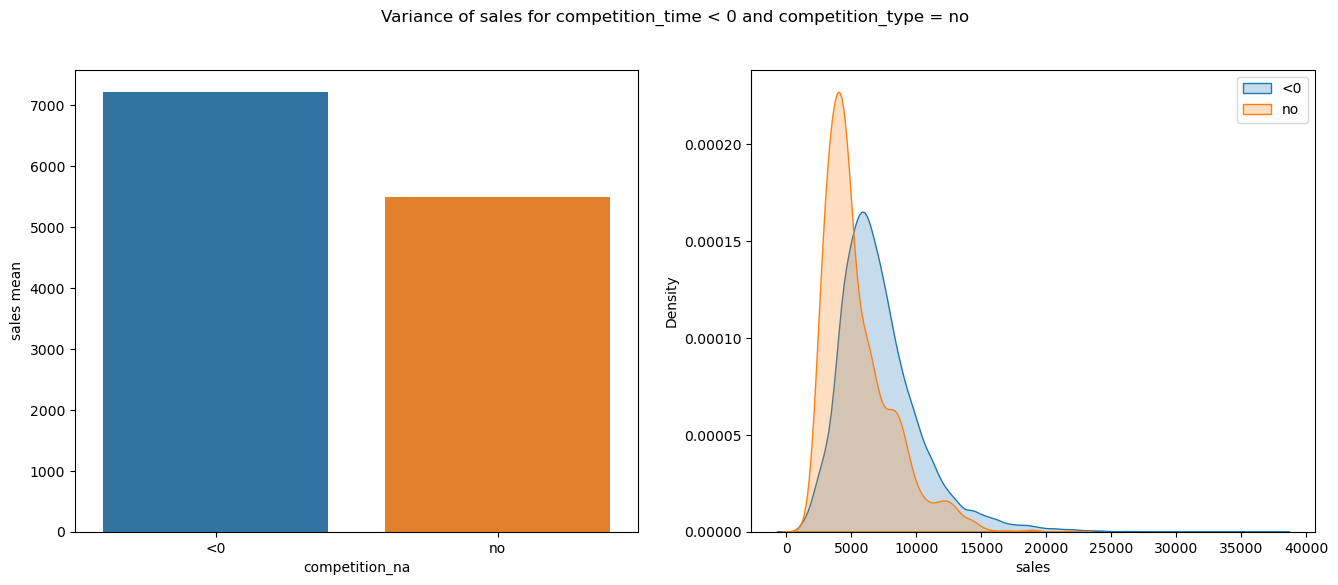

In [93]:
data = trk.get_backup(('competition_type', 'create'), method='<=')

data.loc[data['competition_time'] < 0, 'competition_na'] = '<0'
data.loc[data['competition_type'] == 'no', 'competition_na'] = 'no'
data = data[data['competition_na'].notna()]

data_aux = data[['competition_na', 'sales']].groupby('competition_na').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='competition_na', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['competition_na'] == '<0']['sales'], label='<0', shade=True)
sns.kdeplot(data[data['competition_na'] == 'no']['sales'], label='no', shade=True)
sns.kdeplot(data[data['competition_na'] == 'with']['sales'], label='no', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales for competition_time < 0 and competition_type = no');

In [94]:
print('''Average sales for values of competition_time that have no close competitor differ from those with negative competition_time.
A negative outlier (x - 3 * s) will be assigned to these cases.
It is interesting to make an assessment of how the machine learning models will fit in the case of dropping the ouliers''')

Average sales for values of competition_time that have no close competitor differ from those with negative competition_time.
A negative outlier (x - 3 * s) will be assigned to these cases.
It is interesting to make an assessment of how the machine learning models will fit in the case of dropping the ouliers


In [95]:
def treatNegativeNA_competition_time(data):
    negative_NA = data.loc[(data['competition_time'] < 0), 'competition_time'].mean() - 3 * data.loc[(data['competition_time'] < 0), 'competition_time'].std()
    data.loc[data['competition_type'] == 'no', 'competition_time'] = negative_NA
    return data

trk.add_process('competition_time', 'treatNA', treatNegativeNA_competition_time, 'Change NA values of competition_time to negative outlier for competition_type = no')

print('Changed NA values of competition_time to negative outlier for competition_type = no')

Changed NA values of competition_time to negative outlier for competition_type = no


### NAs (with competition)

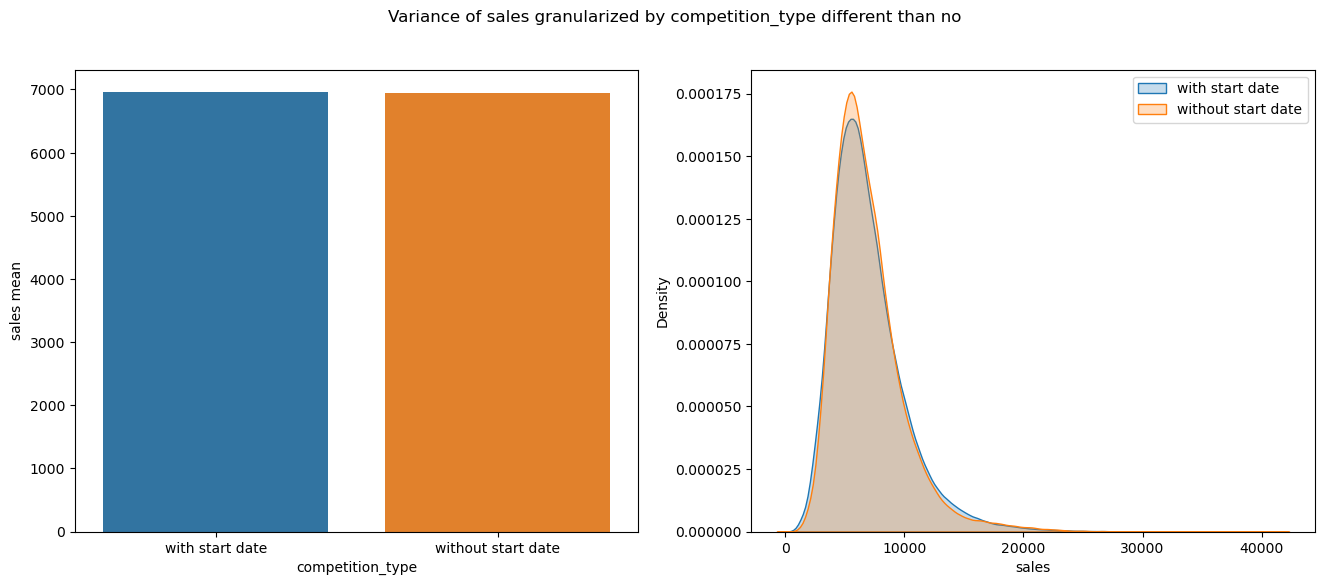

In [97]:
data = trk.get_backup(('competition_type', 'create'), method='<=')

data = data[data['competition_type'] != 'no']

data_aux = data[['competition_type', 'sales']].groupby('competition_type').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='competition_type', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['competition_type'] == 'with start date']['sales'], label='with start date', shade=True)
sns.kdeplot(data[data['competition_type'] == 'without start date']['sales'], label='without start date', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by competition_type different than no');

In [98]:
print('''The mean and distribution curves for the two cases are very similar.
Let's analyze sales by competition_time''')

The mean and distribution curves for the two cases are very similar.
Let's analyze sales by competition_time


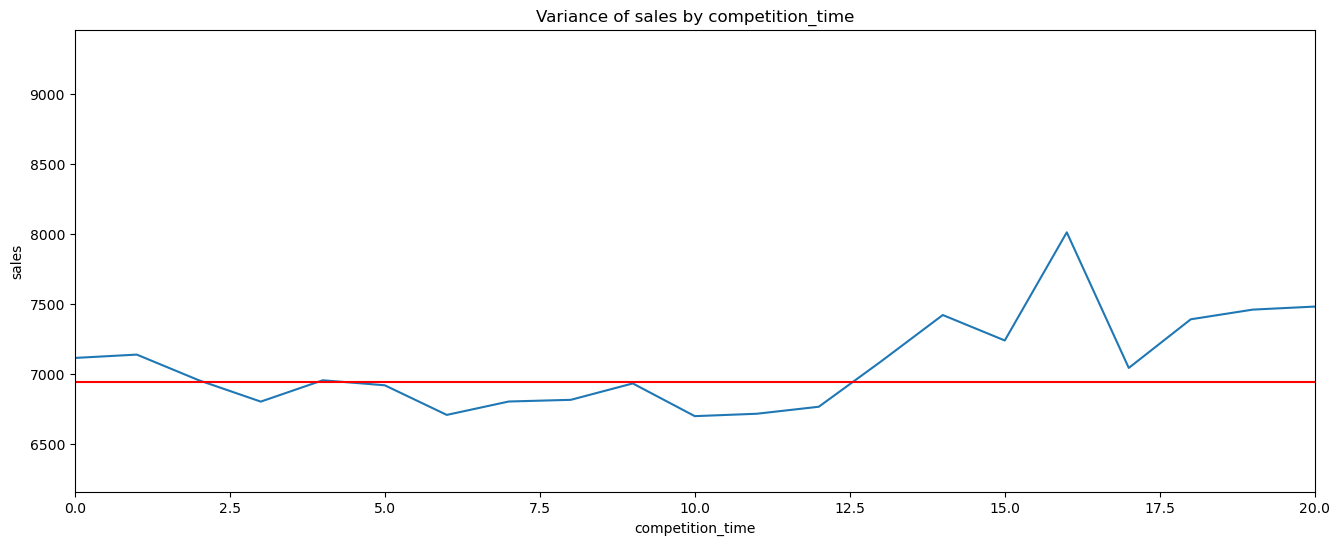

In [99]:
data = trk.data

mean_sales_without = data.loc[(data['competition_type'] == 'without start date'), 'sales'].mean()

data['competition_time'] = data['competition_time'] // 365

data_aux = data[['competition_time', 'sales']].groupby('competition_time').mean().reset_index()

plt.figure(figsize=(16, 6))
#plt.subplot(1, 2, 1)
sns.lineplot(x=data_aux['competition_time'], y=data_aux['sales'])
plt.xlim([0, 20])
plt.hlines(mean_sales_without, 0, 20, 'r')
plt.title('Variance of sales by competition_time');

In [100]:
print('''As shown in the three graphs above, the average sales for values without competition_time almost coincides with the average of the other values.
Considering that the graph curve just above does not show any trend.
Will be assigned to the NAs of stores with competitors but without competition_time positive outliers (x + 3 * s).
As there are many outliers and the variable does not have a strong relationship, I do not recommend dropping the lines.''')

As shown in the three graphs above, the average sales for values without competition_time almost coincides with the average of the other values.
Considering that the graph curve just above does not show any trend.
Will be assigned to the NAs of stores with competitors but without competition_time positive outliers (x + 3 * s).
As there are many outliers and the variable does not have a strong relationship, I do not recommend dropping the lines.


In [101]:
def treatPositiveNA_competition_time(data):
    positive_NA = data.loc[(data['competition_time'] > 0), 'competition_time'].mean() + 3 * data.loc[(data['competition_time'] > 0), 'competition_time'].std()
    data.loc[data['competition_type'] == 'without start date', 'competition_time'] = positive_NA
    return data

trk.add_process('competition_time', 'treatNAPos', treatPositiveNA_competition_time, 'Change NA values of competition_time to positive outlier for competition_type = without start date')

print('Changed NA values of competition_time to positive outlier for competition_type = without start date')

Changed NA values of competition_time to positive outlier for competition_type = without start date


### Robust Scaler

In [102]:
def rescale_competition_time(data):    
    rs = RobustScaler(with_centering=False)
    data['competition_time'] = rs.fit_transform(data[['competition_time']])
    return data

trk.add_process('competition_time', 'rescale', rescale_competition_time, 'Make robust scale with no centering for competition_time', False)

print('Added procces to make robust scale with no centering for competition_time')

Added procces to make robust scale with no centering for competition_time


## competition_type

In [103]:
trk.backup()

### Univariated Analysis

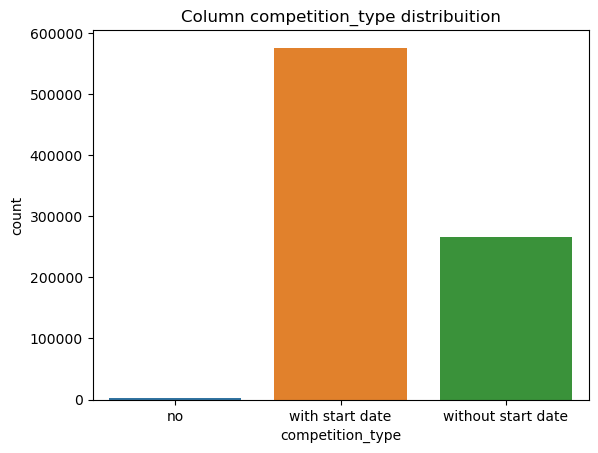

In [104]:
data = trk.data

sns.countplot(x=data['competition_type'].sort_values())
plt.title('Column competition_type distribuition');

In [105]:
print('''There is a small amout of stores/day with no competitors.''')

There is a small amout of stores/day with no competitors.


### Bivariated Analysis

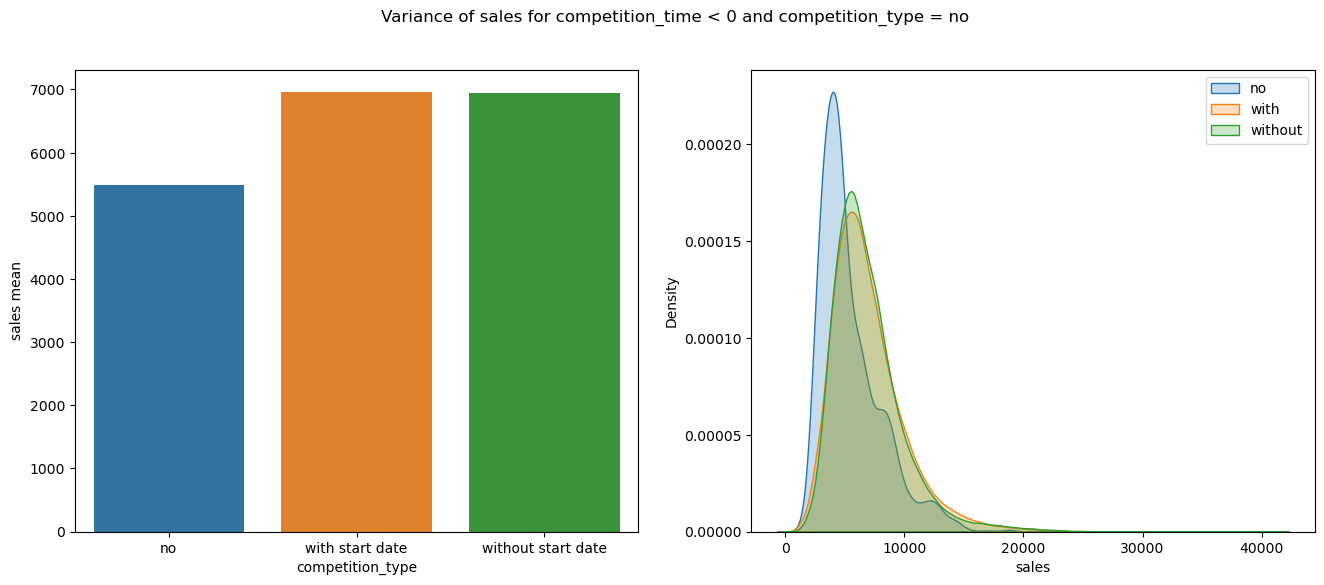

In [106]:
data = trk.data

data_aux = data[['competition_type', 'sales']].groupby('competition_type').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='competition_type', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['competition_type'] == 'no']['sales'], label='no', shade=True)
sns.kdeplot(data[data['competition_type'] == 'with start date']['sales'], label='with', shade=True)
sns.kdeplot(data[data['competition_type'] == 'without start date']['sales'], label='without', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales for competition_time < 0 and competition_type = no');

In [107]:
print('''The is a diference in both mean and distribution for condition_type equal to no.
As big as it is, it won't be very expressive for the general average of the model.
But, for a accurate adjustment, it can be useful''')

The is a diference in both mean and distribution for condition_type equal to no.
As big as it is, it won't be very expressive for the general average of the model.
But, for a accurate adjustment, it can be useful


### Encode

In [11]:
def encode_competition_type(data):
    le = LabelEncoder()
    data['competition_type'] = le.fit_transform(data['competition_type'])
    return data

trk.add_process('competition_type', 'encode', encode_competition_type, 'Encode competition_type with label encoder', False)

print('Added process to encode competition_type with label encoder')

Added process to encode competition_type with label encoder


## promo2

### Univariated Analysis

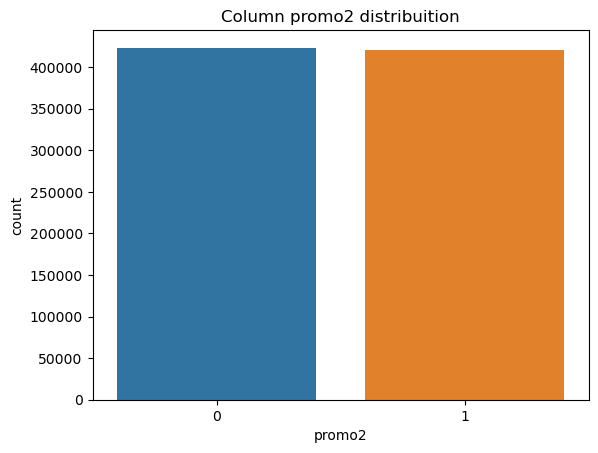

In [108]:
data = trk.data

sns.countplot(x=data['promo2'].sort_values())
plt.title('Column promo2 distribuition');

In [109]:
print('The data is almost perfectly balanced for the variable promo2.')

The data is almost perfectly balanced for the variable promo2.


### Bivariated Analysis

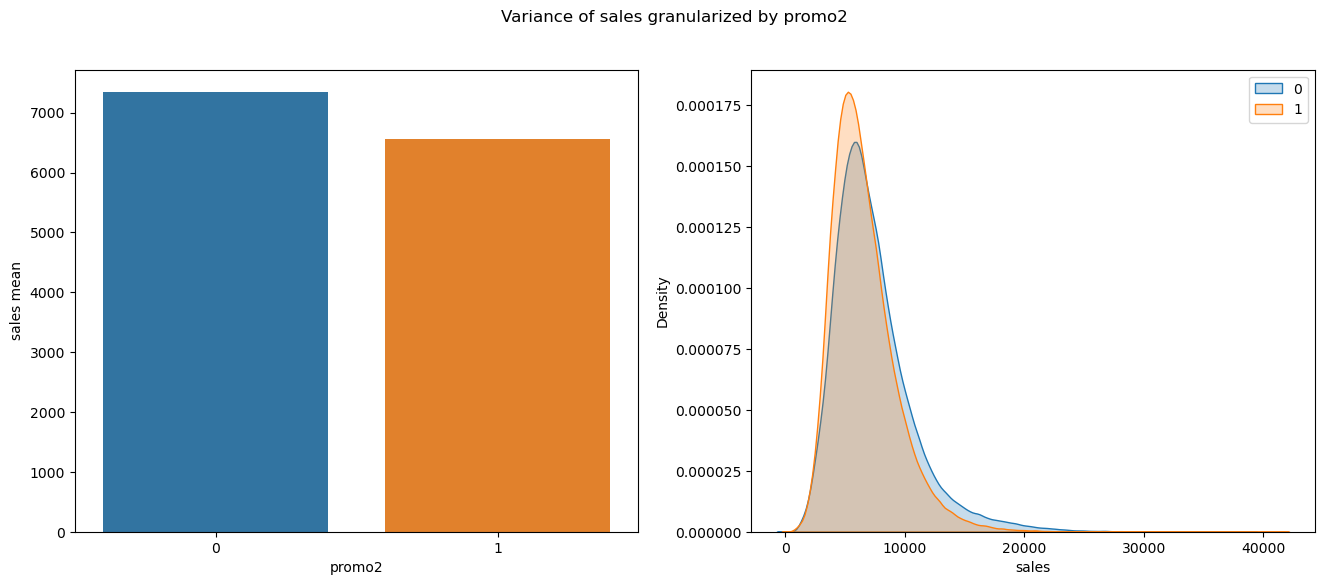

In [110]:
data = trk.data

data_aux = data[['promo2', 'sales']].groupby('promo2').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='promo2', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['promo2'] == 0]['sales'], label='0', shade=True)
sns.kdeplot(data[data['promo2'] == 1]['sales'], label='1', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by promo2');

In [111]:
print('''Stores that do not participate in the promo2 have higher average sales than those that participate.
This analysis does not consider whether the store had promo2 active on that day.
This analysis will be carried out below.''')

Stores that do not participate in the promo2 have higher average sales than those that participate.
This analysis does not consider whether the store had promo2 active on that day.
This analysis will be carried out below.


## promo2_since

### create

In [112]:
def create_promo2_since(data):    
    def convert(x):
        if pd.notna(x['promo2_since_year']):
            p2sy = int(x['promo2_since_year'])
            p2sw = int(x['promo2_since_week'])
            return datetime.strptime(f'{p2sy}-W{p2sw}-1', '%Y-W%W-%w').date()
        return np.nan
    data['promo2_since'] = pd.to_datetime(data.apply(convert, axis=1))
    return data

trk.add_process('promo2_since', 'create', create_promo2_since, 'Create variable promo2_since from promo2_since_year and promo2_since_week')

print('Created variable promo2_since from promo2_since_year and promo2_since_week')

Created variable promo2_since from promo2_since_year and promo2_since_week


In [113]:
trk.backup()

### drop (promo2_since_year/week)

In [114]:
def drop_promo2_since_year_week(data):
    data = data.drop(columns=['promo2_since_year', 'promo2_since_week'])
    
    return data

trk.add_process('promo2_since_year/week', 'drop', drop_promo2_since_year_week, 'Drop variable promo2_since_year/week')

print('Droped variables promo2_since_year/week')

Droped variables promo2_since_year/week


### drop

In [39]:
def drop_promo2_since(data):
    return data.drop(columns=['promo2_since'])

trk.add_process('promo2_since', 'drop', drop_promo2_since, 'Drop column promo2_since', False)

print('Added process to drop column promo2_sice.')

Added process to drop column promo2_sice.


### drop (promo2_interval)

In [7]:
def drop_promo_interval(data):
    return data.drop(columns='promo_interval')

trk.add_process('promo_interval', 'drop', drop_promo_interval, 'Drop column promo_interval', False)

print('Added process to drop column promo_interval')

Added process to drop column promo_interval


## promo2_next

### create

In [115]:
def create_promo2_next(data):
    def get_next(x):
        if pd.notna(x['promo2_since']):
            promo2_months = x['promo_interval'].split(',')
            promo2_months = list(map(lambda y: {'Jan': 1, 'Feb': 2, 'Mar': 3, 
                                                'Apr': 4, 'May': 5, 'Jun': 6, 
                                                'Jul': 7, 'Aug': 8, 'Sept': 9, 
                                                'Oct': 10, 'Nov': 11, 'Dec': 12}.get(y, 1), promo2_months))
            next_promo2 = None
            if x['promo2_since'] > x['date']:       
                next_promo2 = x['promo2_since'] - x['date']
            else:
                year = x['date'].year
                while next_promo2 is None:
                    for month in promo2_months:
                        date_promo2 = datetime(year, month, 1)
                        if date_promo2 >= x['date']:
                            next_promo2 = date_promo2 - x['date']
                            break
                    year += 1
            return next_promo2.days
        return np.nan
    data['promo2_next'] = data.apply(get_next, axis=1)
    return data

trk.add_process('promo2_next', 'create', create_promo2_next, 'Create variable promo2_next with the total days to the next promo.')

print('Created variable promo2_next with the total days to the next promo.')

Created variable promo2_next with the total days to the next promo.


### NAs

In [116]:
def treatNA_promo2_next(data):
    data.loc[data['promo2_next'].isna(), 'promo2_next'] = 9999
    return data

trk.add_process('promo2_next', 'treatNA', treatNA_promo2_next, 'Change NA values to 9999')

print('Changed NA values to 9999')

Changed NA values to 9999


### Type

In [117]:
def retype_promo2_next(data):
    data['promo2_next'] = data['promo2_next'].astype('int64')
    return data

trk.add_process('promo2_next', 'retype', retype_promo2_next, 'Retype promo2_next to int64')

print('Retyped promo2_next to int64')

Retyped promo2_next to int64


In [118]:
trk.backup()

### Univariated Analysis

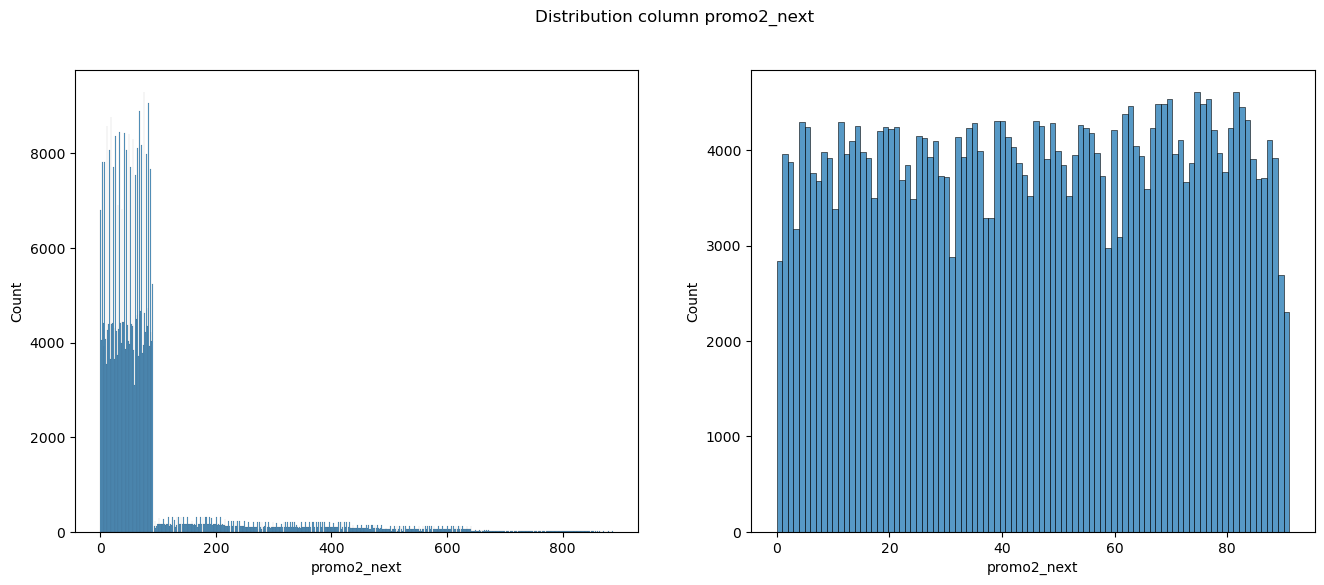

In [119]:
data = trk.data

data = data[data['promo2'] == 1]
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.histplot(data['promo2_next'])
data = data[data['promo2_since'] < data['date']]
plt.subplot(1, 2, 2)
sns.histplot(data['promo2_next'], bins=92)
plt.suptitle('Distribution column promo2_next');

In [120]:
print('''As can be seen above, there is a strong concentration of data up to 92 days.
which is the maximum time for the next type 2 promotion to occur.
The graph on the right shows the data distribution for these cases.''')

As can be seen above, there is a strong concentration of data up to 92 days.
which is the maximum time for the next type 2 promotion to occur.
The graph on the right shows the data distribution for these cases.


### Bivariated Analysis

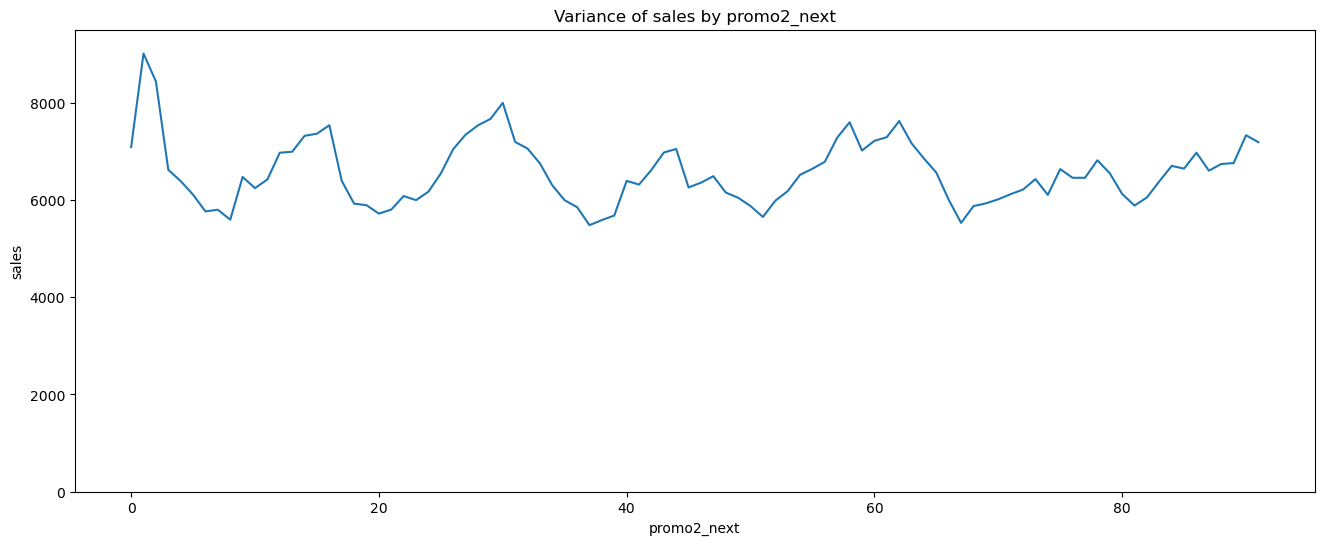

In [121]:
data = trk.data

data = data[(data['promo2'] == 1) & (data['promo2_since'] < data['date'])]
data = data[['promo2_next', 'sales']].groupby('promo2_next').mean().reset_index()

plt.figure(figsize=(16,6))
sns.lineplot(x=data['promo2_next'], y=data['sales'])
plt.ylim([0, 9500])
plt.title('Variance of sales by promo2_next');

In [122]:
print('''The chart above shows a slight downward trend.
There is a noise that apparently repeats itself every month.
It is interesting to analyze later the seasonality of average sales during the month to see if the same pattern exists.''')

The chart above shows a slight downward trend.
There is a noise that apparently repeats itself every month.
It is interesting to analyze later the seasonality of average sales during the month to see if the same pattern exists.


## promo2_previous

In [123]:
def create_promo2_previous(data):
    def get_previous(x):
        if pd.notna(x['promo2_since']):
            promo2_months = x['promo_interval'].split(',')
            promo2_months = list(map(lambda y: {'Jan': 1, 'Feb': 2, 'Mar': 3, 
                                                'Apr': 4, 'May': 5, 'Jun': 6, 
                                                'Jul': 7, 'Aug': 8, 'Sept': 9, 
                                                'Oct': 10, 'Nov': 11, 'Dec': 12}.get(y, 1), promo2_months))
            previous_promo2 = None
            if x['promo2_since'] > x['date']:       
                previous_promo2 = np.nan
            else:
                year = x['date'].year
                while previous_promo2 is None:
                    for month in promo2_months[::-1]:
                        date_promo2 = datetime(year, month, 1)
                        if date_promo2 < x['date']:
                            previous_promo2 = (x['date'] - date_promo2).days
                            break
                    year -= 1
            return previous_promo2
        return np.nan
    data['promo2_previous'] = data.apply(get_previous, axis=1)
    return data

trk.add_process('promo2_previous', 'create', create_promo2_previous, 'Create variable promo2_previous with the total days to the previous promo2.')

print('Created variable promo2_previous with the total days to the previous promo2.')

Created variable promo2_previous with the total days to the previous promo2.


### NAs

In [124]:
def treatNA_promo2_previous(data):
    data.loc[data['promo2_previous'].isna(), 'promo2_previous'] = -9999
    return data

trk.add_process('promo2_previous', 'treatNA', treatNA_promo2_previous, 'Change NA values of promo2_previous to -9999')

print('Changed NA values of promo2_previous to -9999')

Changed NA values of promo2_previous to -9999


### Type

In [125]:
def retype_promo2_previous(data):
    data['promo2_previous'] = data['promo2_previous'].astype('int64')
    return data

trk.add_process('promo2_previous', 'retype', retype_promo2_previous, 'Retype promo2_previous to int64')

print('Retyped promo2_previous to int64')

Retyped promo2_previous to int64


In [126]:
trk.backup()

## promo2_distance

### create

In [127]:
def create_promo2_distance(data):
    def get_smaller(x):
        if x['promo2_next'] <= x['promo2_previous']:
            smaller = x['promo2_next']
        else:
            smaller = -1 * x['promo2_previous']
        return smaller
    data['promo2_distance'] = data.apply(get_smaller, axis=1)
    return data

trk.add_process('promo2_distance', 'create', create_promo2_distance, 'Create promo2_distance with the smaller distance in days to the promo2')

print('Created promo2_distance with the smaller distance in days to the promo2')

Created promo2_distance with the smaller distance in days to the promo2


### Univariated Analysis

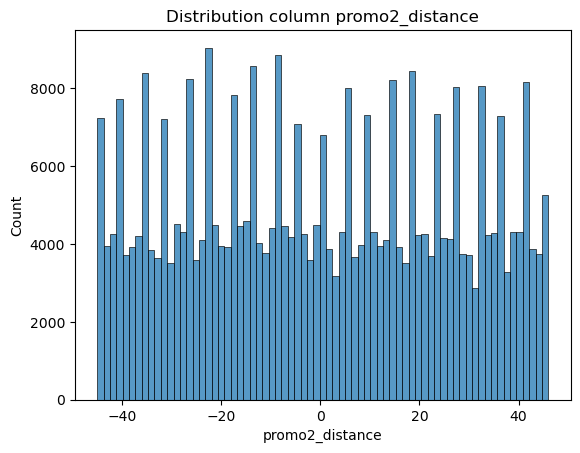

In [128]:
data = trk.data
data = data.loc[data['promo2_distance'].between(-90, 90)]

sns.histplot(data['promo2_distance'])
plt.title('Distribution column promo2_distance');

In [129]:
print('''The data for the distance of days are well balanced between -45 and 45 
with the same (seemingly) weekly noises observed earlier.''')

The data for the distance of days are well balanced between -45 and 45 
with the same (seemingly) weekly noises observed earlier.


### Bivariated Analysis

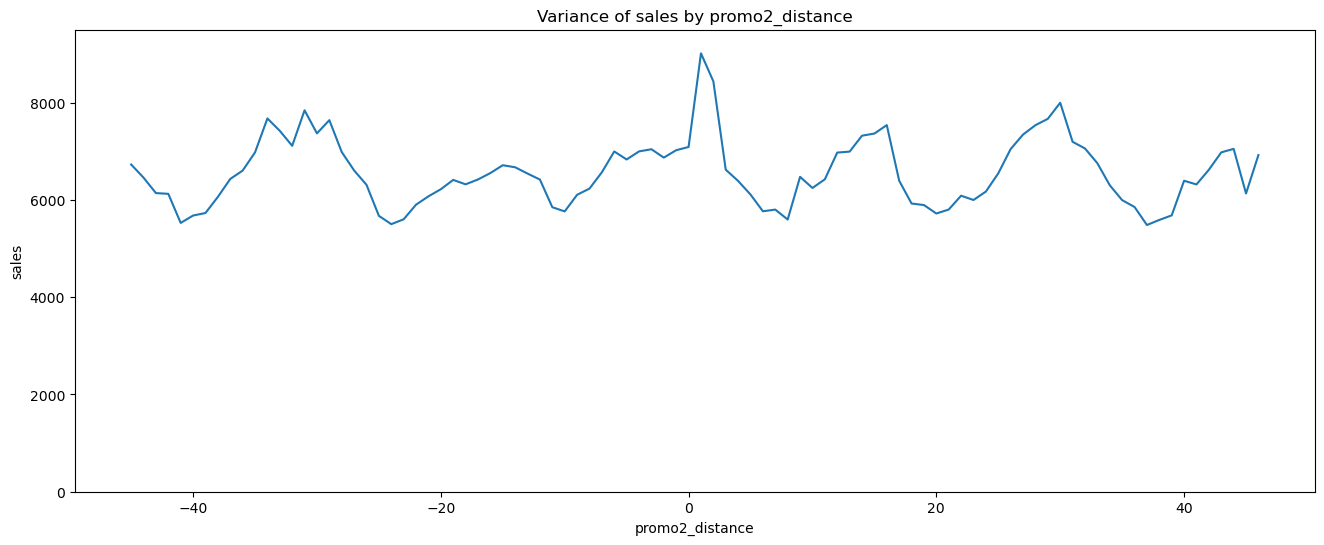

In [130]:
data = trk.data
data = data.loc[data['promo2_distance'].between(-90, 90)]
data = data[['promo2_distance', 'sales']].groupby('promo2_distance').mean().reset_index()

plt.figure(figsize=(16,6))
sns.lineplot(x=data['promo2_distance'], y=data['sales'])
plt.ylim([0, 9500])
plt.title('Variance of sales by promo2_distance');

In [131]:
print('''There appears to be a pattern of rising average sales on day zero of the promotion along with a drop in sales a few days earlier. 
Maybe promotions are increasing sales but just reallocating them.
The same monthly pattern of seasonality can be observed.
It is interesting because there is also the pattern of biweekly seasonality.''')

There appears to be a pattern of rising average sales on day zero of the promotion along with a drop in sales a few days earlier. 
Maybe promotions are increasing sales but just reallocating them.
The same monthly pattern of seasonality can be observed.
It is interesting because there is also the pattern of biweekly seasonality.


In [132]:
trk.backup()

### Multivariated Analysis

In [162]:
def smoth_by(data, smoth_from, smoth_to, by_list):
    data[smoth_to] = data[smoth_from]
    for by in by_list:
        data_aux = data[[by, smoth_to]].groupby(by).mean()
        data[smoth_to] = data.apply(lambda x: x[smoth_to] - data_aux.at[x[by], smoth_to], axis=1)
    return data

In [163]:
data = trk.data
data = data.loc[data['promo2_distance'].between(-90, 90)]
to_smoth = ['day', 'month', 'assortment', 'store_type', 'state_holiday', 'promo', 'week_day']
data = smoth_by(data, 'sales', 'sales_smothed', to_smoth)

In [164]:
delta_mean = data['sales'].mean() - data['sales_smothed'].mean()
data['sales_smothed'] = data['sales_smothed'] + delta_mean
smothed_mean = data['sales_smothed'].mean()
smothed_std = data['sales_smothed'].std()
data['sales_smothedstd'] = data['sales_smothed'] - smothed_mean

def supress_std(x):
    if x >= 0:
        x -= 1.96 * smothed_std
        return x if x > 0 else 0
    else:
        x += 1.96 * smothed_std
        return x if x < 0 else 0
    
data['sales_smothedstd'] = data['sales_smothedstd'].map(supress_std)

data['sales_smothedstd'] = data['sales_smothedstd'] + smothed_mean

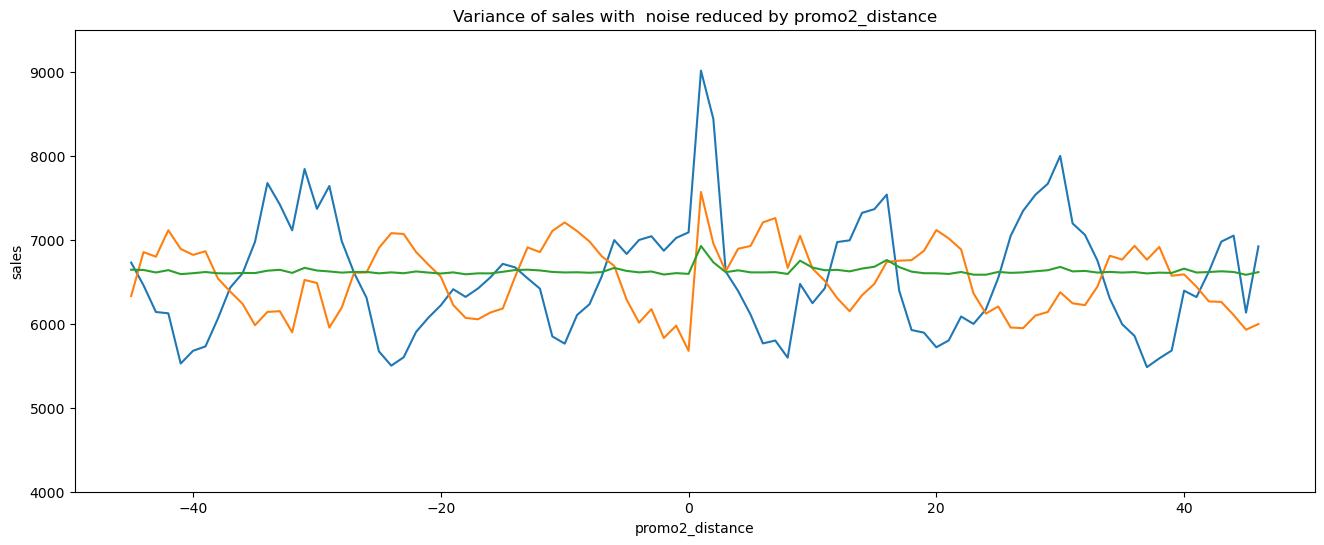

In [165]:
plt.figure(figsize=(16,6))

data_aux = data[['promo2_distance', 'sales', 'sales_smothed', 'sales_smothedstd']].groupby('promo2_distance').mean().reset_index()

sns.lineplot(x=data_aux['promo2_distance'], y=data_aux['sales'])
sns.lineplot(x=data_aux['promo2_distance'], y=data_aux['sales_smothed'])
sns.lineplot(x=data_aux['promo2_distance'], y=data_aux['sales_smothedstd'])
plt.ylim([4000, 9500])
plt.title('Variance of sales with  noise reduced by promo2_distance');

In [166]:
print('''There is a clear pattern on the first day of promo2 that follows a pattern of falling sales on the previous days.
Looking closely at the green curve, it is possible to see that there is a peak every 15 days. 
It may be that this promotion is carried out with intervals of 15 days. But this is just an assumption.''')

There is a clear pattern on the first day of promo2 that follows a pattern of falling sales on the previous days.
Looking closely at the green curve, it is possible to see that there is a peak every 15 days. 
It may be that this promotion is carried out with intervals of 15 days. But this is just an assumption.


## year

### create

In [135]:
def create_year(data):
    data['year'] = data['date'].dt.year
    return data

trk.add_process('year', 'create', create_year, 'Create column year with the year of the sale')

print('Created column year with the year of the sale')

Created column year with the year of the sale


### Univariated Analysis

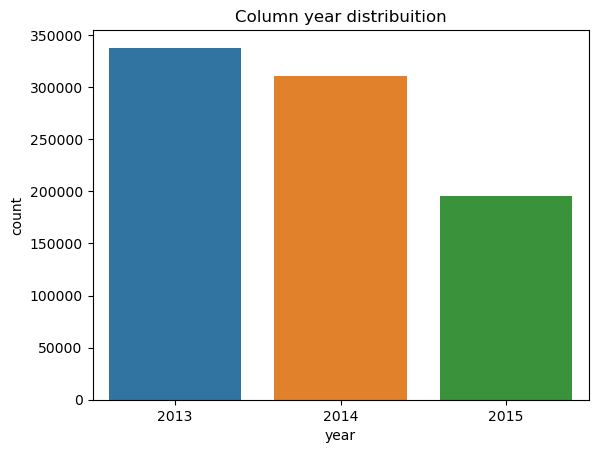

In [136]:
data = trk.data

sns.countplot(x=data['year'])
plt.title('Column year distribuition');

### Bivariated Analysis

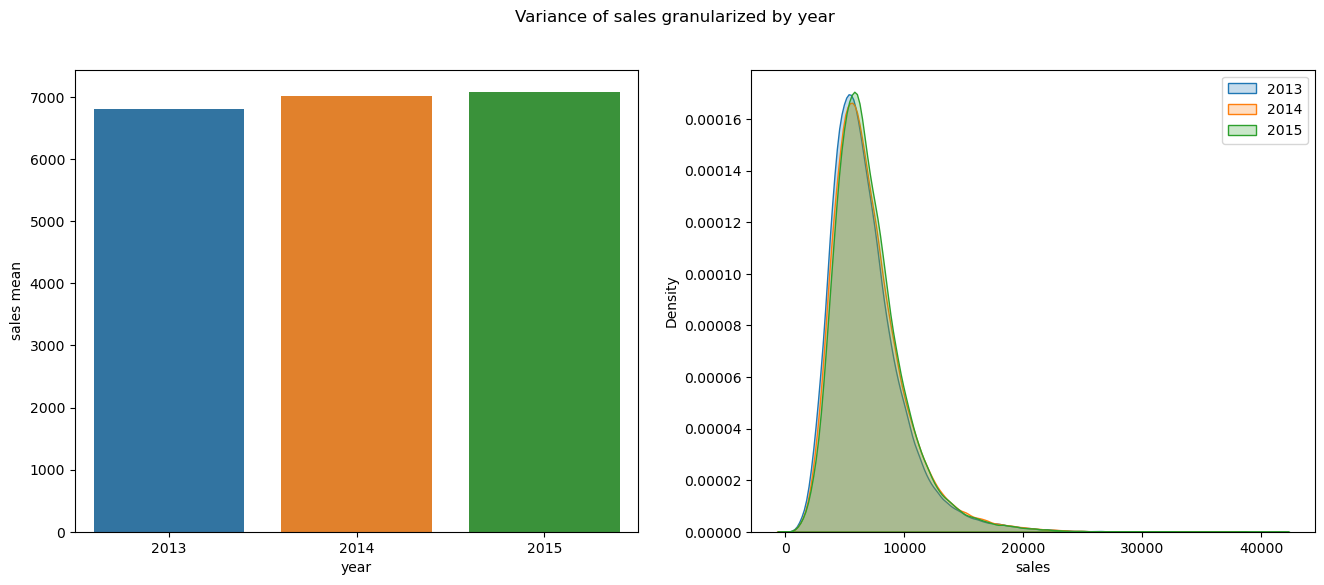

In [137]:
data = trk.data

data_aux = data[['year', 'sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='year', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['year'] == 2013]['sales'], label='2013', shade=True)
sns.kdeplot(data[data['year'] == 2014]['sales'], label='2014', shade=True)
sns.kdeplot(data[data['year'] == 2015]['sales'], label='2015', shade=True)
plt.legend()
fig.subplots_adjust(wspace=0.15)
plt.suptitle('Variance of sales granularized by year');

In [138]:
print('There is a slight trend for average sales to grow over the years.')

There is a slight trend for average sales to grow over the years.


## month

### create

In [139]:
def create_month(data):
    data['month'] = data['date'].dt.month
    return data

trk.add_process('month', 'create', create_month, 'Create column month with the month of the sale')

print('Created column month with the month of the sale')

Created column month with the month of the sale


### Univariated Analysis

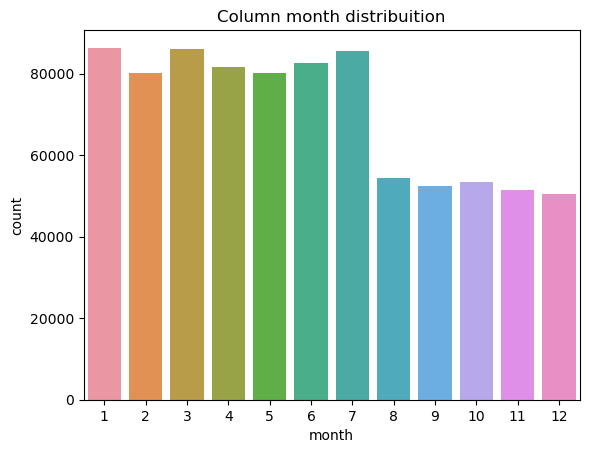

In [140]:
data = trk.data

sns.countplot(x=data['month'])
plt.title('Column month distribuition');

In [141]:
print('The decrease in the number of registrations from August is due to the data that ends before the end of the year')

The decrease in the number of registrations from August is due to the data that ends before the end of the year


### Bivariated Analysis

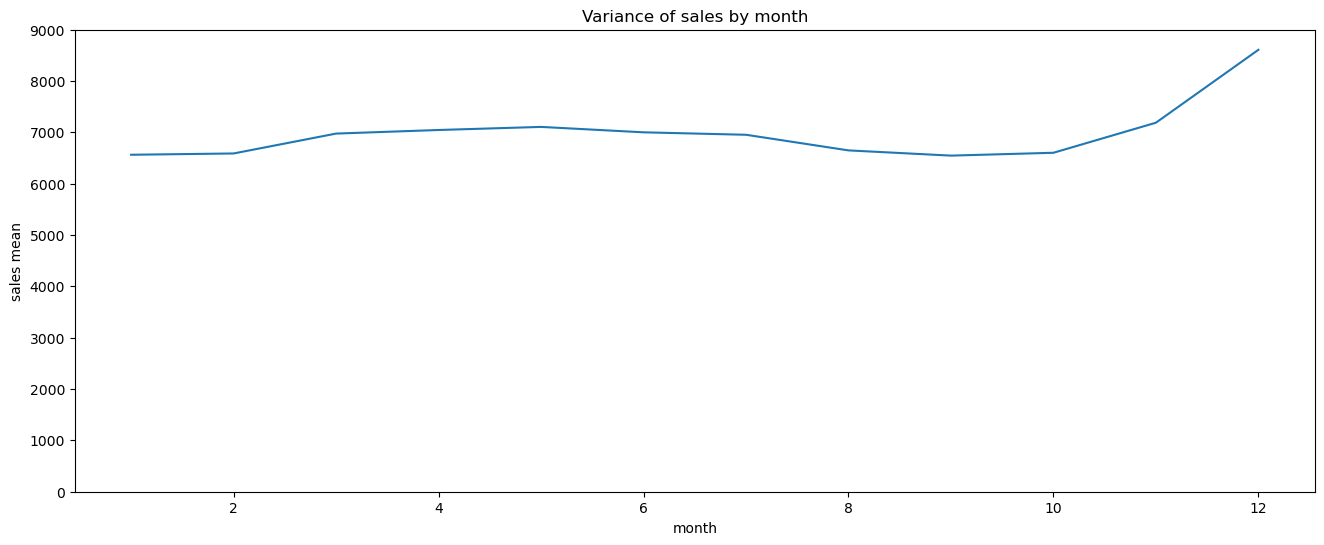

In [142]:
data = trk.data

data_aux = data[['month', 'sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(16, 6))

sns.lineplot(x='month', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.ylim([0, 9000])
plt.title('Variance of sales by month');

In [143]:
print('''There is a clear relationship between average sales and the month of sale.
This relationship demonstrates that the beginning of years are weaker, the equivalent of the 3rd quarter as well.
The end of the year has a higher average of sales.''')

There is a clear relationship between average sales and the month of sale.
This relationship demonstrates that the beginning of years are weaker, the equivalent of the 3rd quarter as well.
The end of the year has a higher average of sales.


### Nature Transformation

In [144]:
def nature_month(data):
    data['month_sin'] = data['month'].apply(lambda x: np.sin(2 * np.pi * (x / 12)))
    data['month_cos'] = data['month'].apply(lambda x: np.cos(2 * np.pi * (x / 12)))
    return data

trk.add_process('month', 'nature', nature_month, 'Create two columns with the nature transformation (sin/cos) for month', False)

print('Added process to create two columns with the nature transformation (sin/cos) for month')

Added process to create two columns with the nature transformation (sin/cos) for month


## day

### create

In [145]:
def create_day(data):
    data['day'] = data['date'].dt.day
    return data

trk.add_process('day', 'create', create_day, 'Create column day with the day of the month of the sale')

print('Created column day with the day of the month of the sale')

Created column day with the day of the month of the sale


### Univariated Analysis

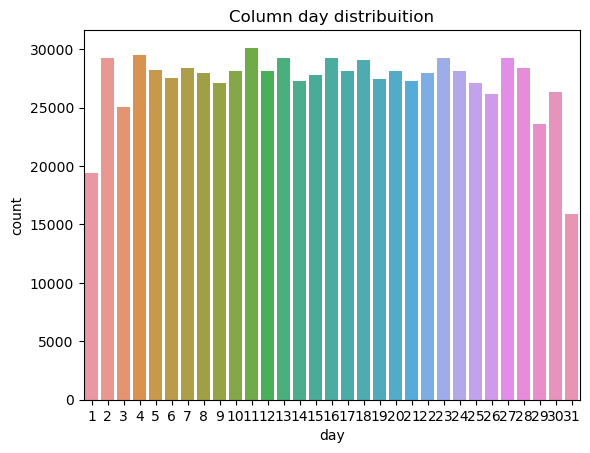

In [146]:
data = trk.data

sns.countplot(x=data['day'])
plt.title('Column day distribuition');

In [147]:
print('The decrease of the number of registers at for 31 is because of neither all months have 31 days')

The decrease of the number of registers at for 31 is because of neither all months have 31 days


### Bivariated Analysis

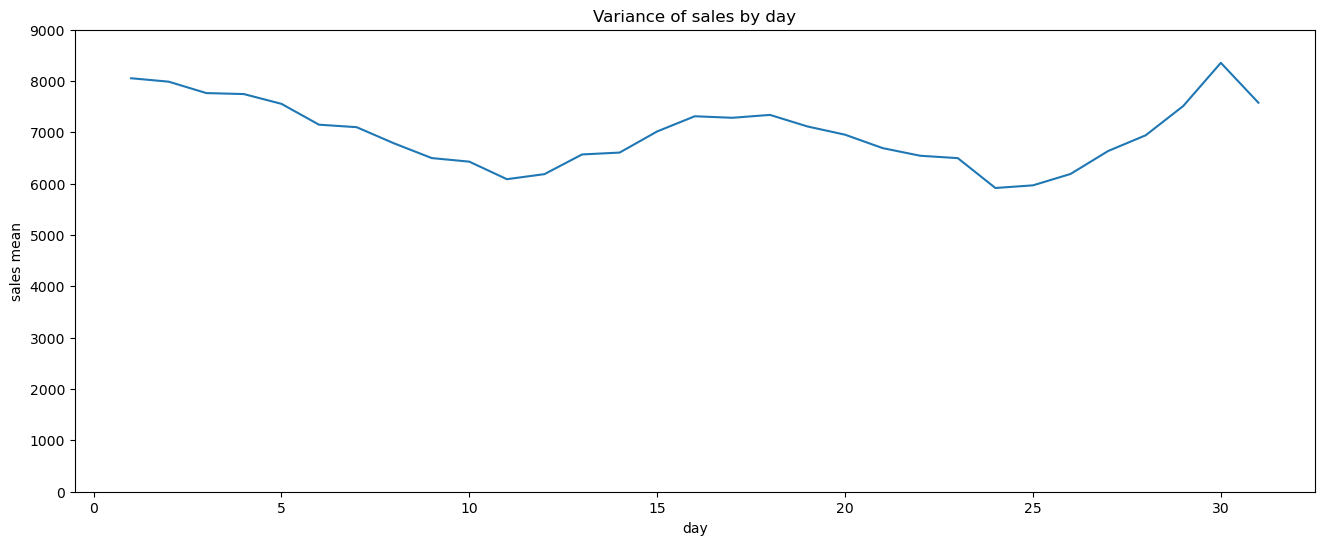

In [148]:
data = trk.data

data_aux = data[['day', 'sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(16, 6))

sns.lineplot(x='day', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.ylim([0, 9000])
plt.title('Variance of sales by day');

In [149]:
print('''There is a well-defined pattern between average sales and the day of the month.
The curve has two peaks (beginning of the month and middle of the month).
This same pattern was observed in the sales curves by promo2_since''')

There is a well-defined pattern between average sales and the day of the month.
The curve has two peaks (beginning of the month and middle of the month).
This same pattern was observed in the sales curves by promo2_since


### Nature Transformation

In [150]:
def nature_day(data):
    data['day_sin'] = data['day'].apply(lambda x: np.sin(2 * np.pi * (x / 30)))
    data['day_cos'] = data['day'].apply(lambda x: np.cos(2 * np.pi * (x / 30)))
    return data

trk.add_process('day', 'nature', nature_day, 'Create two columns with the nature transformation (sin/cos) for day', False)

print('Added process to create two columns with the nature transformation (sin/cos) for day')

Added process to create two columns with the nature transformation (sin/cos) for day


## week

### create

In [151]:
def create_week(data):
    data['week'] = data['date'].dt.isocalendar().week.astype('int64')
    return data

trk.add_process('week', 'create', create_week, 'Create column week with the week of the year of the sale.')

print('Created column week with the week of the year of the sale.')

Created column week with the week of the year of the sale.


### Univariated Analysis

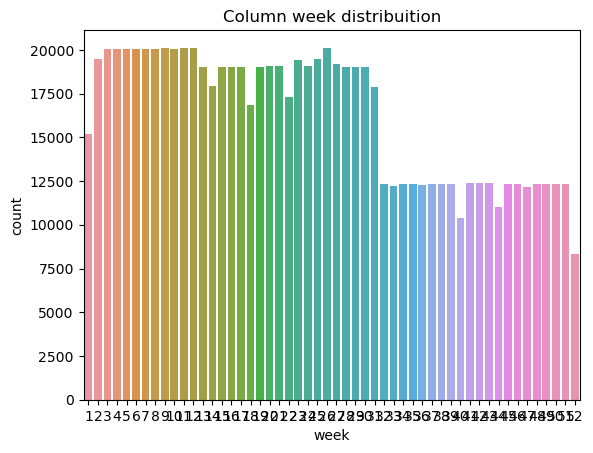

In [152]:
data = trk.data

sns.countplot(x=data['week'])
plt.title('Column week distribuition');

In [ ]:
print('The decrease in the number of registers from August is due to the data that ends before the end of the year')

### Bivariated Analysis

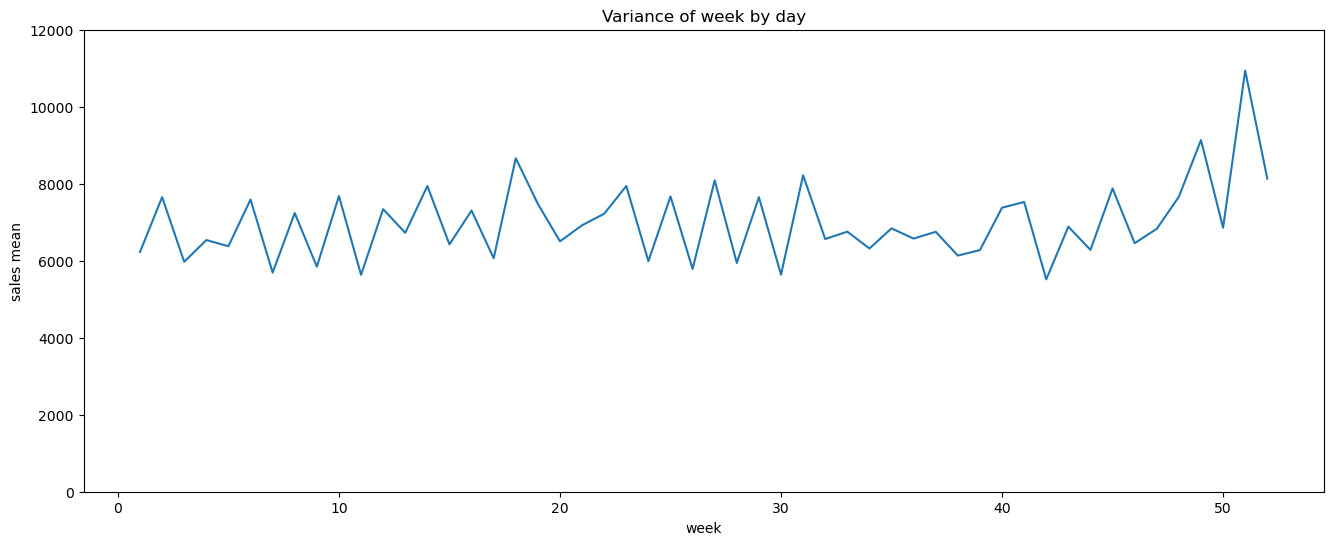

In [153]:
data = trk.data

data_aux = data[['week', 'sales']].groupby('week').mean().reset_index()

plt.figure(figsize=(16, 6))

sns.lineplot(x='week', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.ylim([0, 12000])
plt.title('Variance of week by day');

In [154]:
print('''The direction of the curve alternates each week.
This pattern matches with the same pattern seen in the curve of sales by day-of-month.''')

The direction of the curve alternates each week.
This pattern matches with the same pattern seen in the curve of sales by day-of-month.


### Nature Transformation

In [155]:
def nature_week(data):
    data['week_sin'] = data['week'].apply(lambda x: np.sin(2 * np.pi * (x / 52)))
    data['week_cos'] = data['week'].apply(lambda x: np.cos(2 * np.pi * (x / 52)))
    return data

trk.add_process('week', 'nature', nature_week, 'Create two columns with the nature transformation (sin/cos) for week', False)

print('Added process to create two columns with the nature transformation (sin/cos) for week')

Added process to create two columns with the nature transformation (sin/cos) for week


## week_day

### rename

In [156]:
def rename_week_day(data):
    data = data.rename(columns={'day_of_week': 'week_day'})
    return data

trk.add_process('week_day', 'rename', rename_week_day, 'Rename column day_of_week to week_day.')

print('Rename column day_of_week to week_day.')

Rename column day_of_week to week_day.


### Univariated Analysis

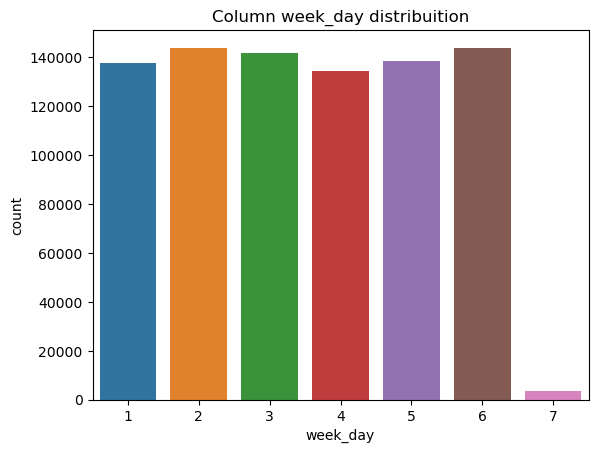

In [157]:
data = trk.data

sns.countplot(x=data['week_day'])
plt.title('Column week_day distribuition');

In [158]:
print('The data records are well balanced for data during the week, with the exception of Sundays.')

The data records are well balanced for data during the week, with the exception of Sundays.


### Bivariated Analysis

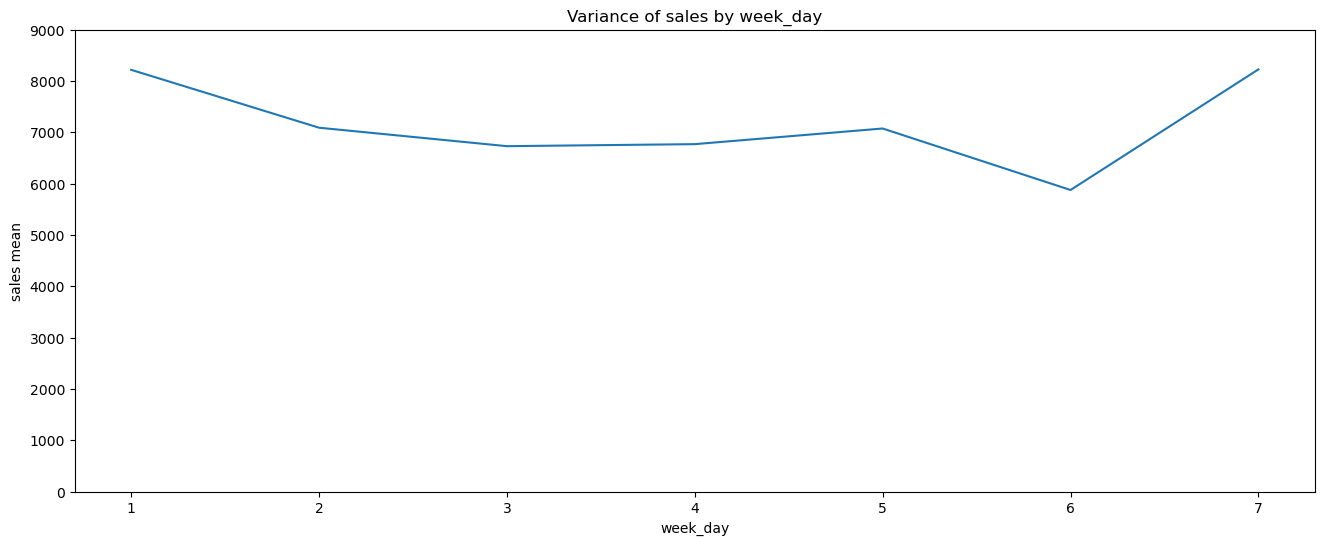

In [159]:
data = trk.data

data_aux = data[['week_day', 'sales']].groupby('week_day').mean().reset_index()

plt.figure(figsize=(16, 6))

sns.lineplot(x='week_day', y='sales', data=data_aux)
plt.ylabel('sales mean')
plt.ylim([0, 9000])
plt.title('Variance of sales by week_day');

In [160]:
print('''The average of sales shows a decrease along the days of the week with a slight rise from the middle of the week.
It's interesting how on Saturday the average plummets.
The high value for Sundays needs to be verified in view of the smaller amount of data for this day.''')

The average of sales shows a decrease along the days of the week with a slight rise from the middle of the week.
It's interesting how on Saturday the average plummets.
The high value for Sundays needs to be verified in view of the smaller amount of data for this day.


### Nature Transformation

In [161]:
def nature_week_day(data):
    data['week_day_sin'] = data['week_day'].apply(lambda x: np.sin(2 * np.pi * (x / 7)))
    data['week_day_cos'] = data['week_day'].apply(lambda x: np.cos(2 * np.pi * (x / 7)))
    return data

trk.add_process('week_day', 'nature', nature_week_day, 'Create two columns with the nature transformation (sin/cos) for week_day', False)

print('Added process to create two columns with the nature transformation (sin/cos) for week_day')

Added process to create two columns with the nature transformation (sin/cos) for week_day


In [44]:
trk.save('tracker')

There is already another tracker saved with this name. Do you want to continue? [Y to continue]Y
Compressing data...
Tracker saved as tracker.trk!


# Machine Learning Modeling

## Linear Regression

### Preprocessing

In [4]:
print('Processes untracked available to be runned:')
trk.get_processes(tracked=False)

Processes untracked available to be runned:


[('sales', 'reshape'),
 ('state_holiday', 'encode'),
 ('store_type', 'relabel'),
 ('assortment', 'encode'),
 ('competition_distance', 'rescaler'),
 ('competition_time', 'rescale'),
 ('month', 'nature'),
 ('day', 'nature'),
 ('week', 'nature'),
 ('week_day', 'nature'),
 ('customers', 'drop'),
 ('promo2_since', 'drop'),
 ('promo_interval', 'drop'),
 ('competition_type', 'encode')]

In [4]:
processes = [('sales', 'reshape'),
             ('state_holiday', 'encode'),
             ('store_type', 'relabel'),
             ('assortment', 'encode'),
             ('competition_distance', 'rescaler'),
             ('competition_time', 'rescale'),
             ('month', 'nature'),
             ('day', 'nature'),
             ('week', 'nature'),
             ('week_day', 'nature'),
             ('customers', 'drop'),
             ('promo2_since', 'drop'),
             ('promo_interval', 'drop'),
             ('competition_type', 'encode')]


data = trk.data
print('Preprocessing carried out with the following processes:')
data = trk.run(data, processes)

Preprocessing carried out with the following processes:
[sales/reshape] - Reshape column sales to get closer to a normal distribution
[state_holiday/encode] - Add process to do the label encode on state_holiday
[store_type/relabel] - Make label encoder on store_type
[assortment/encode] - Make ordinal encoder with assortment order: basic, extra, extended.
[competition_distance/rescaler] - Rescale competition_distance using the min value and the third quantile
[competition_time/rescale] - Make robust scale with no centering for competition_time
[month/nature] - Create two columns with the nature transformation (sin/cos) for month
[day/nature] - Create two columns with the nature transformation (sin/cos) for day
[week/nature] - Create two columns with the nature transformation (sin/cos) for week
[week_day/nature] - Create two columns with the nature transformation (sin/cos) for week_day
[customers/drop] - Drop column customers
[promo2_since/drop] - Drop column promo2_since
[promo_interval

### Features Selection

In [12]:
print('Available columns:')
data.columns

Available columns:


Index(['store', 'week_day', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'promo2', 'competition_time', 'competition_type', 'promo2_next',
       'promo2_previous', 'promo2_distance', 'year', 'month', 'day', 'week',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos',
       'week_day_sin', 'week_day_cos'],
      dtype='object')

In [13]:
features = ['store', 'week_day', 'promo', 'state_holiday',
            'school_holiday', 'store_type', 'assortment', 'competition_distance',
            'promo2', 'competition_time', 'competition_type', 'promo2_next',
            'promo2_previous', 'promo2_distance', 'year', 'month', 'day', 'week',
            'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos',
            'week_day_sin', 'week_day_cos']

In [14]:
X = data[features]
y = data['sales']
time_series = data['date']
folds = tscv.get_folds(time_series, offset=timedelta(days=60), k_folds=1, test_size=timedelta(days=60))

X_train, X_test, y_train, y_test = tscv.train_test_split(X, y, time_series, **folds[1])

def metric(y_test, y_pred):
    return mt.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

lr = LinearRegression()
analysis = fst.metric_decreases_by_pair(X_train, X_test, y_train, y_test, lr, metric, verbose=False)

In [15]:
analysis[['metric', 'suffered_decrease_mean', 'suffered_decrease_std', 'caused_decrease_mean', 'caused_decrease_std']].sort_values('caused_decrease_mean')

,metric,suffered_decrease_mean,suffered_decrease_std,caused_decrease_mean,caused_decrease_std
promo,2000.951414,-4.995670,8.806418,-262.017611,10.083565
week_day,2207.560019,-12.578458,43.272645,-55.030762,8.310302
week_day_sin,2234.706068,-14.384694,46.988669,-28.677356,5.175556
assortment,2239.158868,-16.467737,52.051417,-26.212808,0.992806
day_cos,2250.456339,-16.093268,49.041167,-14.073991,2.412795
promo2,2251.988336,-15.582372,51.663711,-11.949485,4.045800
promo2_next,2252.123540,-15.598281,51.652163,-11.825316,4.026646
school_holiday,2254.729153,-15.761031,49.226911,-9.284739,2.581669
promo2_distance,2255.261137,-16.032490,51.533533,-9.013792,3.659455
promo2_previous,2255.290650,-16.035871,51.530687,-8.986615,3.652524


In [50]:
#analysis[(analysis['caused_decrease_mean'] + analysis['caused_decrease_std']) < -10].index
fixed = ['week_day', 'promo', 'assortment', 'day_cos', 'week_day_sin'] 
#analysis[((analysis['caused_decrease_mean'] + analysis['caused_decrease_std']) >= -10) & 
#         ((analysis['caused_decrease_mean'] - analysis['caused_decrease_std']) < 0)].index
combine = ['school_holiday', 'store_type', 'promo2', 'competition_time',
           'competition_type', 'promo2_next', 'promo2_previous', 'promo2_distance',
           'year', 'month', 'week', 'month_sin', 'day_sin', 'week_sin',
           'week_day_cos']
#combine = ['school_holiday', 'year', 'month', 'week', 'month_sin', 'month_cos', 'week_day_cos', 'week_sin', 'week_cos'] 

print('Features that will be fixed in all combinations:')
print(fixed)
print('')
print('Features that will be combined:')
print(combine)

Features that will be fixed in all combinations:
['week_day', 'promo', 'assortment', 'day_cos', 'week_day_sin']

Features that will be combined:
['school_holiday', 'store_type', 'promo2', 'competition_time', 'competition_type', 'promo2_next', 'promo2_previous', 'promo2_distance', 'year', 'month', 'week', 'month_sin', 'day_sin', 'week_sin', 'week_day_cos']


In [37]:
result = fst.sum_cross_combinations(analysis, fixed, combine, True)

Combinations taken 15 by 15.


In [38]:
print('Best cobination of features found:')
result[0]

Best cobination of features found:


(['school_holiday',
  'store_type',
  'promo2',
  'competition_time',
  'competition_type',
  'promo2_next',
  'promo2_previous',
  'promo2_distance',
  'year',
  'month',
  'week',
  'month_sin',
  'day_sin',
  'week_sin',
  'week_day_cos',
  'week_day',
  'promo',
  'assortment',
  'day_cos',
  'week_day_sin'],
 -8476.26349286666)

### Modeling

In [51]:
features = ['school_holiday', 'store_type', 'promo2', 'competition_time', 'competition_type', 'promo2_next',
            'promo2_previous', 'promo2_distance', 'year', 'month', 'week', 'month_sin', 'day_sin', 'week_sin',
            'week_day_cos', 'week_day', 'promo', 'assortment', 'day_cos', 'week_day_sin']

In [47]:
X = data[features]
y = data['sales']
time_series = data['date']
lr = LinearRegression()

folds = tscv.get_folds(time_series, offset=timedelta(days=60), k_folds=6, test_size=timedelta(days=60))

def metric(y_test, y_pred):
    return mt.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

results = tscv.validate(folds, X, y, time_series, lr, metric)

Multi-period validation completed!


### Metrics

In [52]:
print('Final mean absolute error:')
tscv.view_folds_frame(results).mean()

Final mean absolute error:


metric    1977.424837
dtype: float64

## Random Forest Regression

### Preprocessing

In [53]:
print('Processes untracked available to be runned:')
trk.get_processes(tracked=False)

Processes untracked available to be runned:


[('sales', 'reshape'),
 ('state_holiday', 'encode'),
 ('store_type', 'relabel'),
 ('assortment', 'encode'),
 ('competition_distance', 'rescaler'),
 ('competition_time', 'rescale'),
 ('month', 'nature'),
 ('day', 'nature'),
 ('week', 'nature'),
 ('week_day', 'nature'),
 ('customers', 'drop'),
 ('promo2_since', 'drop'),
 ('promo_interval', 'drop'),
 ('competition_type', 'encode')]

In [54]:
processes = [('sales', 'reshape'),
             ('state_holiday', 'encode'),
             ('store_type', 'relabel'),
             ('assortment', 'encode'),
             ('competition_distance', 'rescaler'),
             ('competition_time', 'rescale'),
             ('month', 'nature'),
             ('day', 'nature'),
             ('week', 'nature'),
             ('week_day', 'nature'),
             ('customers', 'drop'),
             ('promo2_since', 'drop'),
             ('promo_interval', 'drop'),
             ('competition_type', 'encode')]


data = trk.data
print('Preprocessing carried out with the following processes:')
data = trk.run(data, processes)

Preprocessing carried out with the following processes:
[sales/reshape] - Reshape column sales to get closer to a normal distribution
[state_holiday/encode] - Add process to do the label encode on state_holiday
[store_type/relabel] - Make label encoder on store_type
[assortment/encode] - Make ordinal encoder with assortment order: basic, extra, extended.
[competition_distance/rescaler] - Rescale competition_distance using the min value and the third quantile
[competition_time/rescale] - Make robust scale with no centering for competition_time
[month/nature] - Create two columns with the nature transformation (sin/cos) for month
[day/nature] - Create two columns with the nature transformation (sin/cos) for day
[week/nature] - Create two columns with the nature transformation (sin/cos) for week
[week_day/nature] - Create two columns with the nature transformation (sin/cos) for week_day
[customers/drop] - Drop column customers
[promo2_since/drop] - Drop column promo2_since
[promo_interval

### Features Selection

In [55]:
print('Available columns:')
data.columns

Available columns:


Index(['store', 'week_day', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'promo2', 'competition_time', 'competition_type', 'promo2_next',
       'promo2_previous', 'promo2_distance', 'year', 'month', 'day', 'week',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos',
       'week_day_sin', 'week_day_cos'],
      dtype='object')

In [56]:
features = ['store', 'week_day', 'promo', 'state_holiday',
            'school_holiday', 'store_type', 'assortment', 'competition_distance',
            'promo2', 'competition_time', 'competition_type', 'promo2_next',
            'promo2_previous', 'promo2_distance', 'year', 'month', 'day', 'week',
            'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_sin', 'week_cos',
            'week_day_sin', 'week_day_cos']

In [58]:
X = data[features]
y = data['sales']
time_series = data['date']
folds = tscv.get_folds(time_series, offset=timedelta(days=60), k_folds=1, test_size=timedelta(days=60))

X_train, X_test, y_train, y_test = tscv.train_test_split(X, y, time_series, **folds[1])

def metric(y_test, y_pred):
    return mt.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

rfr = RandomForestRegressor(n_estimators=2)
analysis = fst.metric_decreases_by_pair(X_train, X_test, y_train, y_test, rfr, metric, verbose=True)

Analysing (26 of 26) week_day_cos


In [59]:
analysis[['metric', 'suffered_decrease_mean', 'suffered_decrease_std', 'caused_decrease_mean', 'caused_decrease_std']].sort_values('caused_decrease_mean')

,metric,suffered_decrease_mean,suffered_decrease_std,caused_decrease_mean,caused_decrease_std
store,1493.757993,-81.276096,133.917958,-786.518989,117.380934
competition_distance,1884.533197,-111.026382,108.984957,-411.324235,99.531804
promo,2000.808590,-64.465973,208.595268,-242.284186,78.476485
week,2086.175561,-54.527070,195.289078,-146.944663,80.132352
week_cos,2109.816620,-70.085852,193.379276,-137.334013,77.426983
week_day_sin,2187.461793,-92.624545,197.962723,-77.926496,57.530762
week_day,2187.767707,-92.565533,197.710882,-77.584443,57.096969
day,2172.562189,-67.603445,186.288974,-64.909179,51.144651
day_sin,2198.959642,-82.056972,172.533676,-54.318407,45.348770
day_cos,2195.499261,-73.358051,173.033058,-49.797367,42.011689


In [65]:
#analysis[(analysis['caused_decrease_mean'] + analysis['caused_decrease_std']) < -10].index
fixed = ['store', 'week_day', 'promo', 'assortment', 'competition_distance', 'day', 'week', 'week_cos', 'week_day_sin'] 
#analysis[((analysis['caused_decrease_mean'] + analysis['caused_decrease_std']) >= -10) & 
#         ((analysis['caused_decrease_mean'] - analysis['caused_decrease_std']) < 0)].index
combine = ['state_holiday', 'school_holiday', 'store_type', 'promo2',
           'competition_type', 'promo2_next', 'promo2_previous', 'promo2_distance',
           'year', 'month', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
           'week_sin', 'week_day_cos']

print('Features that will be fixed in all combinations:')
print(fixed)
print('')
print('Features that will be combined:')
print(combine)

Features that will be fixed in all combinations:
['store', 'week_day', 'promo', 'assortment', 'competition_distance', 'day', 'week', 'week_cos', 'week_day_sin']

Features that will be combined:
['state_holiday', 'school_holiday', 'store_type', 'promo2', 'competition_type', 'promo2_next', 'promo2_previous', 'promo2_distance', 'year', 'month', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_sin', 'week_day_cos']


In [66]:
result = fst.sum_cross_combinations(analysis, fixed, combine, True)

Combinations taken 16 by 16.


In [83]:
[(k, len(res[0]), res[1]) for k, res in enumerate(result) if len(res[0]) == 20]

[(2266, 20, -45584.71736057353),
 (2323, 20, -45469.598959908726),
 (2334, 20, -45435.82233801614),
 (2344, 20, -45412.78699388065),
 (2354, 20, -45391.19101125861),
 (2362, 20, -45358.0587639849),
 (2367, 20, -45352.39646455544),
 (2375, 20, -45334.413300991975),
 (2376, 20, -45332.6330673295),
 (2382, 20, -45321.16891227703),
 (2425, 20, -45232.226831221225),
 (2426, 20, -45225.85804587945),
 (2427, 20, -45225.31676764032),
 (2428, 20, -45224.94343000987),
 (2429, 20, -45222.731620645296),
 (2433, 20, -45193.15841155315),
 (2434, 20, -45188.85121240674),
 (2435, 20, -45187.961830032385),
 (2436, 20, -45182.63090786731),
 (2437, 20, -45179.815435858785),
 (2439, 20, -45171.75747098801),
 (2440, 20, -45168.95061119536),
 (2450, 20, -45156.65996490555),
 (2451, 20, -45156.12834703528),
 (2452, 20, -45153.57133970049),
 (2457, 20, -45139.23895340357),
 (2459, 20, -45133.514038087145),
 (2460, 20, -45133.491003266696),
 (2462, 20, -45119.20221592766),
 (2464, 20, -45116.04737785915),
 (24

In [82]:
print('Best cobination of features found:')
result[0]

Best cobination of features found:


(['state_holiday',
  'school_holiday',
  'store_type',
  'promo2',
  'competition_type',
  'promo2_next',
  'promo2_previous',
  'promo2_distance',
  'year',
  'month',
  'month_sin',
  'month_cos',
  'day_sin',
  'day_cos',
  'week_sin',
  'week_day_cos',
  'store',
  'week_day',
  'promo',
  'assortment',
  'competition_distance',
  'day',
  'week',
  'week_cos',
  'week_day_sin'],
 -57526.73230182038)

### Modeling

In [84]:
features = ['state_holiday', 'school_holiday', 'store_type', 'promo2', 'competition_type', 'promo2_next', 'promo2_previous',
            'promo2_distance', 'year', 'month', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_sin', 'week_day_cos',
            'store', 'week_day', 'promo', 'assortment', 'competition_distance', 'day', 'week', 'week_cos', 'week_day_sin']

In [85]:
X = data[features]
y = data['sales']
time_series = data['date']
rfr = RandomForestRegressor(n_estimators=2)

folds = tscv.get_folds(time_series, offset=timedelta(days=60), k_folds=6, test_size=timedelta(days=60))

def metric(y_test, y_pred):
    return mt.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

results = tscv.validate(folds, X, y, time_series, rfr, metric)

Multi-period validation completed!


### Metrics

In [86]:
print('Final mean absolute error:')
tscv.view_folds_frame(results).mean()

Final mean absolute error:


metric    908.568346
dtype: float64

# Best Model Tuning (BET)

# Deploy

# Saving Tracker

In [17]:
trk.backup()

In [87]:
trk.status()

 flags | order - scope - action - description 
   b   |     0 - _general_ - rename - Rename all columns to snake_case
   b   |     1 - sales - treatNA - Drop lines with NAs or 0 values to sales
     x |     2 - sales - reshape - Reshape column sales to get closer to a normal distribution
   b   |     3 - date - retype - Retype column date from object to datetime64[ns]
       |     4 - open - drop - Drop column open
       |     5 - state_holiday - relabel - Relabel the column state_holiday to more descriptive names (public, easter, christmas, no)
   b x |     6 - state_holiday - encode - Add process to do the label encode on state_holiday
     x |     7 - store_type - relabel - Make label encoder on store_type
       |     8 - assortment - relabel - Relabel the column assortment to more descriptive names (basic, extra, extended)
     x |     9 - assortment - encode - Make ordinal encoder with assortment order: basic, extra, extended.
       |    10 - competition_distance - treatNA - Ch

In [ ]:
trk.save('tracker')

There is already another tracker saved with this name. Do you want to continue? [Y to continue]Y
